# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pickle
import itertools
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

# b. MNIST Data Loader

In [2]:
tensor_transform = transforms.Compose([
    transforms.ToTensor(),
		transforms.Normalize(mean=(0.5, ), std=(0.5, ))
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. Unconditional GAN**


# a. Training Function for Discriminator

In [4]:
criterion = nn.BCELoss()

def train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels):
    discriminator.zero_grad()
    if with_condition:
      outputs = discriminator(images, cls_labels)
    else:
      outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels.view(-1, 1))
    real_score = outputs

    if with_condition:
      outputs = discriminator(fake_images, cls_labels)
    else:
      outputs = discriminator(fake_images)

    fake_loss = criterion(outputs, fake_labels.view(-1, 1))
    fake_score = outputs

    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss, real_score, fake_score, fake_loss

# b. Training Function for Generator

In [5]:
def train_generator(generator, g_optimizer, discriminator_outputs, real_labels, with_condition):
    generator.zero_grad()
    g_loss = criterion(discriminator_outputs, real_labels.view(-1, 1))
    g_loss_fake = criterion(discriminator_outputs, 1 - real_labels.view(-1, 1))
    g_loss.backward()
    g_optimizer.step()
    return g_loss, g_loss_fake

# c. Monitors for Images and Losses


In [6]:
def monitor_images(generator, test_noise, with_condition):
    num_test_samples = test_noise.shape[0]
    size_figure_grid = int(math.sqrt(num_test_samples))
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(4, 4))
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)

    if with_condition:
      cls_labels = torch.randint(0, 10, (num_test_samples,)).to(device)
      test_images = generator(test_noise, label = cls_labels)
    else:
      test_images = generator(test_noise)

    for k in range(num_test_samples):
        i = k//4
        j = k%4
        ax[i,j].cla()
        ax[i,j].imshow(test_images[k,:].data.cpu().numpy().reshape(28, 28), cmap='Greys')
        if with_condition:
            ax[i, j].set_title(f'Class: {cls_labels[k].item()}', fontsize=10)
    plt.show()


def monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake):
    def moving_average(x, win=100):
        return np.convolve(x, np.ones(win), 'same') / np.convolve(np.ones_like(x), np.ones(win), 'same')

    plt.figure(figsize=(8, 3))
    iters = np.arange(len(d_losses))
    epochs = iters * batch_size / 60000
    plt.plot(epochs, moving_average(d_losses), label='d_loss')
    plt.plot(epochs, moving_average(g_losses), label='g_loss')
    plt.plot(epochs, moving_average(d_losses_fake), label='d_loss_fake')
    plt.plot(epochs, moving_average(g_losses_fake), label='g_loss_fake')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


# c. Model for Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, channels=[512, 256, 128], with_condition=False):
        super().__init__()
        self.with_condition = with_condition
        self.model = None

        ##################
        ### Problem 1: Implement Discriminator
        ##################
        self.model = [
            nn.Linear(784, channels[0]),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
        ]
        for i in range(len(channels) - 1):
            self.model += [
                nn.Linear(channels[i], channels[i + 1]),
                nn.LeakyReLU(),
                nn.Dropout(0.2),
            ]
        self.model += [nn.Linear(channels[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), 784)
        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out


with torch.no_grad():
    discriminator = Discriminator(with_condition=False).to(device)
    for iter, (images, labels) in enumerate(test_loader):
        images = images.to(device)  # (128, 1, 28, 8)
        labels = labels.to(device)  # (128,)
        print(discriminator(images, labels).shape)
        break

torch.Size([128, 1])


# e. Model for Generator


In [8]:
class Generator(nn.Module):
    def __init__(self, dim_z=100, channels=[128, 256, 512], with_condition=False):
        super().__init__()
        self.dim_z = dim_z
        self.with_condition = with_condition

        self.model = None
        ##################
        ### Problem 1: Implement Generator
        ##################
        self.model = [nn.Linear(dim_z, channels[0]), nn.LeakyReLU()]
        for i in range(len(channels) - 1):
            self.model += [nn.Linear(channels[i], channels[i + 1]), nn.LeakyReLU()]
        self.model += [nn.Linear(channels[-1], 784), nn.Tanh()]
        self.model = nn.Sequential(*self.model)

    def forward(self, x, label=None):
        x = x.view(x.size(0), self.dim_z)

        if self.with_condition:
            assert label is not None
            ##################
            ### Problem 3: Implement Conditional GAN
            ##################

        out = self.model(x)
        return out


with torch.no_grad():
    generator = Generator(with_condition=False).to(device)
    noise = Variable(torch.randn(batch_size, generator.dim_z)).to(device)
    print(generator(noise).shape)

torch.Size([128, 784])


# d. Training

In [9]:
num_batches = len(train_loader)

def train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise,
                    num_epochs, d_freq, with_condition):
  d_losses = []
  g_losses = []
  d_losses_fake = []
  g_losses_fake = []
  dim_z = generator.dim_z
  for epoch in range(num_epochs):
      for n, (images, cls_labels) in enumerate(train_loader):
          images = Variable(images.to(device)) # (batch_size, 1, 28, 28)
          real_labels = Variable(torch.ones(images.size(0)).to(device)) # (batch_size, )
          cls_labels = cls_labels.to(device) # (batch_size, )

          # Sample from generator
          noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)
          fake_images = generator(noise, label=cls_labels if with_condition else None) # (batch_size, 784)
          fake_labels = Variable(torch.zeros(images.size(0)).to(device)) # (batch_size, )

          # Train the discriminator
          d_loss, real_score, fake_score, d_loss_fake = train_discriminator(discriminator, d_optimizer, images, real_labels, fake_images, fake_labels, with_condition, cls_labels=cls_labels)

          if n % d_freq == 0:
            noise = Variable(torch.randn(images.size(0), dim_z).to(device)) # (batch_size, dim_z)

            # Sample again from the generator and get output from discriminator
            fake_images = generator(noise, label=cls_labels if with_condition else None)
            outputs = discriminator(fake_images, label=cls_labels if with_condition else None)

            # Train the generator
            g_loss, g_loss_fake = train_generator(generator, g_optimizer, outputs, real_labels, with_condition)



          d_losses.append(d_loss.data.detach().cpu().numpy())
          g_losses.append(g_loss.data.detach().cpu().numpy())
          d_losses_fake.append(d_loss_fake.data.detach().cpu().numpy())
          g_losses_fake.append(g_loss_fake.data.detach().cpu().numpy())

          if (n+1) % 100 == 0:
              print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, d_loss_fake: %.4f, g_loss: %.4f, g_loss_fake: %.4f, '
                    'D(x): %.2f, D(G(z)): %.2f'
                    %(epoch + 1, num_epochs, n+1, num_batches, d_loss.data, d_loss_fake.data, g_loss.data, g_loss_fake.data,
                      real_score.data.mean(), fake_score.data.mean()))
      if epoch in [0, 19] or (epoch+1) % 50 == 0:
        torch.save(discriminator.state_dict(), f'/workspace/GAN_ablation1_disc_epoch={epoch+1}.pt')
        torch.save(generator.state_dict(), f'/workspace/GAN_ablation1_gen_epoch={epoch+1}.pt')

      if epoch == 0 or (epoch+1) % 5 == 0:
        monitor_images(generator, test_noise, with_condition=with_condition)
        monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)
  return d_losses, d_losses_fake, g_losses, g_losses_fake

In [ ]:
# set number of epochs and initialize figure counter
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)



In [ ]:
# I have pretrained 60 epochs. So the epochs of the results below are epoch + 60
num_epochs = 160
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# e. Ablation Study

Epoch [1/200], Step[100/469], d_loss: 0.2514, d_loss_fake: 0.1486, g_loss: 3.3251, g_loss_fake: 0.0416, D(x): 0.97, D(G(z)): 0.14
Epoch [1/200], Step[200/469], d_loss: 1.2974, d_loss_fake: 1.0519, g_loss: 0.6205, g_loss_fake: 0.8082, D(x): 0.81, D(G(z)): 0.64
Epoch [1/200], Step[300/469], d_loss: 1.0321, d_loss_fake: 0.5734, g_loss: 1.6727, g_loss_fake: 0.2455, D(x): 0.87, D(G(z)): 0.42
Epoch [1/200], Step[400/469], d_loss: 0.2725, d_loss_fake: 0.0871, g_loss: 4.0055, g_loss_fake: 0.0382, D(x): 0.84, D(G(z)): 0.08


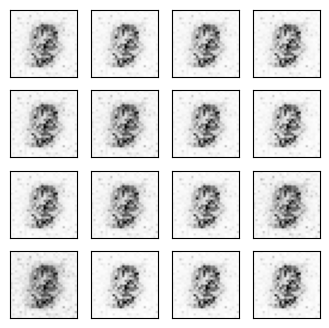

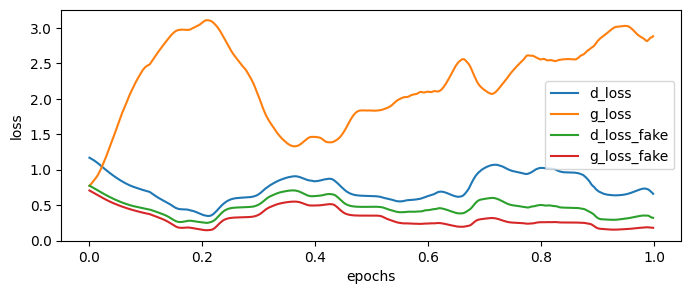

Epoch [2/200], Step[100/469], d_loss: 1.2922, d_loss_fake: 0.7343, g_loss: 0.8901, g_loss_fake: 0.6155, D(x): 0.64, D(G(z)): 0.50
Epoch [2/200], Step[200/469], d_loss: 0.4050, d_loss_fake: 0.1775, g_loss: 2.0665, g_loss_fake: 0.1477, D(x): 0.83, D(G(z)): 0.16
Epoch [2/200], Step[300/469], d_loss: 0.2047, d_loss_fake: 0.1333, g_loss: 2.2764, g_loss_fake: 0.1275, D(x): 0.95, D(G(z)): 0.12
Epoch [2/200], Step[400/469], d_loss: 0.3671, d_loss_fake: 0.2018, g_loss: 3.5475, g_loss_fake: 0.0520, D(x): 0.90, D(G(z)): 0.16
Epoch [3/200], Step[100/469], d_loss: 0.3289, d_loss_fake: 0.1373, g_loss: 3.8562, g_loss_fake: 0.0810, D(x): 0.88, D(G(z)): 0.11
Epoch [3/200], Step[200/469], d_loss: 0.3456, d_loss_fake: 0.1837, g_loss: 2.5425, g_loss_fake: 0.1119, D(x): 0.88, D(G(z)): 0.16
Epoch [3/200], Step[300/469], d_loss: 0.2564, d_loss_fake: 0.0628, g_loss: 4.2483, g_loss_fake: 0.0495, D(x): 0.88, D(G(z)): 0.06
Epoch [3/200], Step[400/469], d_loss: 0.2441, d_loss_fake: 0.0984, g_loss: 3.0458, g_loss_

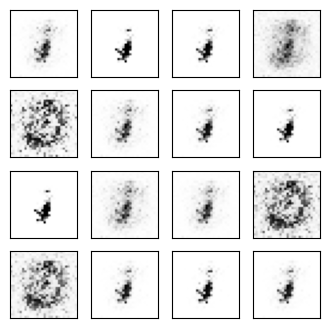

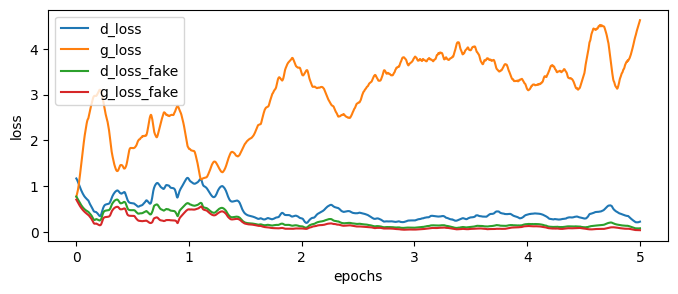

Epoch [6/200], Step[100/469], d_loss: 0.2420, d_loss_fake: 0.0857, g_loss: 2.8820, g_loss_fake: 0.0730, D(x): 0.92, D(G(z)): 0.08
Epoch [6/200], Step[200/469], d_loss: 0.0553, d_loss_fake: 0.0346, g_loss: 4.3671, g_loss_fake: 0.0188, D(x): 0.98, D(G(z)): 0.03
Epoch [6/200], Step[300/469], d_loss: 0.5155, d_loss_fake: 0.3218, g_loss: 3.0582, g_loss_fake: 0.1487, D(x): 0.89, D(G(z)): 0.19
Epoch [6/200], Step[400/469], d_loss: 0.3538, d_loss_fake: 0.2303, g_loss: 2.8843, g_loss_fake: 0.1280, D(x): 0.92, D(G(z)): 0.18
Epoch [7/200], Step[100/469], d_loss: 0.3022, d_loss_fake: 0.1774, g_loss: 3.8535, g_loss_fake: 0.0842, D(x): 0.93, D(G(z)): 0.10
Epoch [7/200], Step[200/469], d_loss: 0.1828, d_loss_fake: 0.0445, g_loss: 4.7301, g_loss_fake: 0.0219, D(x): 0.93, D(G(z)): 0.04
Epoch [7/200], Step[300/469], d_loss: 0.3910, d_loss_fake: 0.2106, g_loss: 2.8027, g_loss_fake: 0.1475, D(x): 0.90, D(G(z)): 0.14
Epoch [7/200], Step[400/469], d_loss: 0.4425, d_loss_fake: 0.2001, g_loss: 2.9215, g_loss_

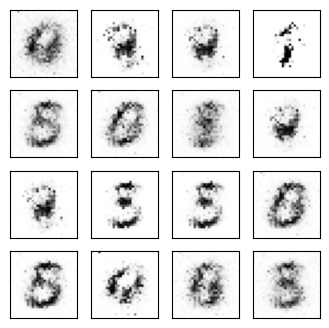

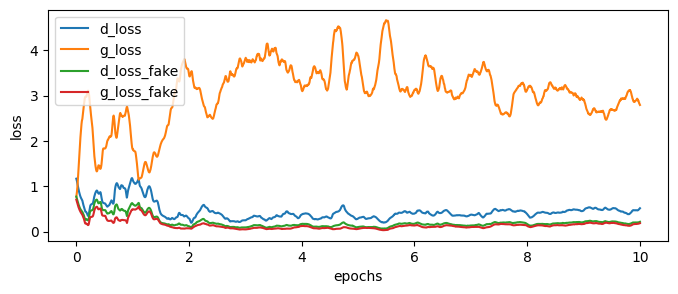

Epoch [11/200], Step[100/469], d_loss: 0.5372, d_loss_fake: 0.3353, g_loss: 3.1996, g_loss_fake: 0.1377, D(x): 0.90, D(G(z)): 0.17
Epoch [11/200], Step[200/469], d_loss: 0.2492, d_loss_fake: 0.0906, g_loss: 3.7616, g_loss_fake: 0.0767, D(x): 0.91, D(G(z)): 0.08
Epoch [11/200], Step[300/469], d_loss: 0.2391, d_loss_fake: 0.0619, g_loss: 3.3224, g_loss_fake: 0.1369, D(x): 0.89, D(G(z)): 0.05
Epoch [11/200], Step[400/469], d_loss: 0.3275, d_loss_fake: 0.1936, g_loss: 3.2750, g_loss_fake: 0.1137, D(x): 0.91, D(G(z)): 0.12
Epoch [12/200], Step[100/469], d_loss: 0.5281, d_loss_fake: 0.1858, g_loss: 2.7291, g_loss_fake: 0.1463, D(x): 0.81, D(G(z)): 0.10
Epoch [12/200], Step[200/469], d_loss: 0.2861, d_loss_fake: 0.1862, g_loss: 3.5827, g_loss_fake: 0.1157, D(x): 0.94, D(G(z)): 0.10
Epoch [12/200], Step[300/469], d_loss: 0.3105, d_loss_fake: 0.1119, g_loss: 3.6825, g_loss_fake: 0.1212, D(x): 0.88, D(G(z)): 0.09
Epoch [12/200], Step[400/469], d_loss: 0.4255, d_loss_fake: 0.2905, g_loss: 2.3763,

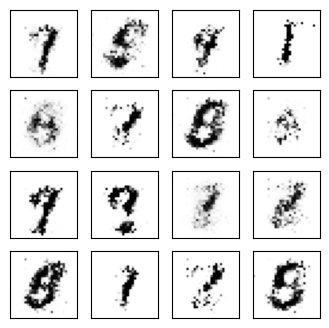

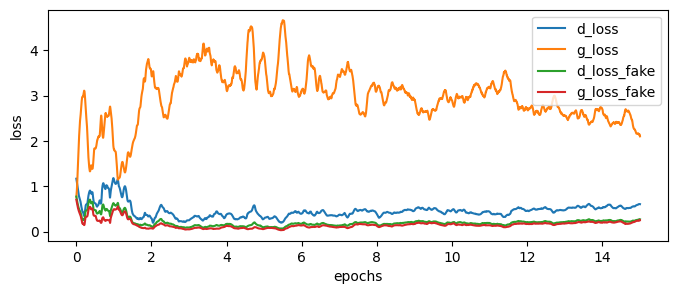

Epoch [16/200], Step[100/469], d_loss: 0.5383, d_loss_fake: 0.2881, g_loss: 2.3484, g_loss_fake: 0.2692, D(x): 0.85, D(G(z)): 0.21
Epoch [16/200], Step[200/469], d_loss: 0.7140, d_loss_fake: 0.3914, g_loss: 1.7760, g_loss_fake: 0.3051, D(x): 0.80, D(G(z)): 0.28
Epoch [16/200], Step[300/469], d_loss: 0.6527, d_loss_fake: 0.2115, g_loss: 2.0308, g_loss_fake: 0.3101, D(x): 0.78, D(G(z)): 0.15
Epoch [16/200], Step[400/469], d_loss: 0.5990, d_loss_fake: 0.2774, g_loss: 2.1199, g_loss_fake: 0.2178, D(x): 0.80, D(G(z)): 0.21
Epoch [17/200], Step[100/469], d_loss: 0.6089, d_loss_fake: 0.3143, g_loss: 1.9095, g_loss_fake: 0.2854, D(x): 0.82, D(G(z)): 0.21
Epoch [17/200], Step[200/469], d_loss: 0.6391, d_loss_fake: 0.3402, g_loss: 1.9618, g_loss_fake: 0.2430, D(x): 0.83, D(G(z)): 0.25
Epoch [17/200], Step[300/469], d_loss: 0.6204, d_loss_fake: 0.2543, g_loss: 1.9657, g_loss_fake: 0.2851, D(x): 0.79, D(G(z)): 0.19
Epoch [17/200], Step[400/469], d_loss: 0.6306, d_loss_fake: 0.3067, g_loss: 2.2516,

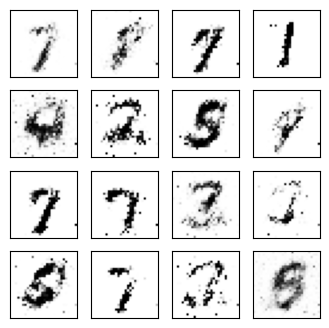

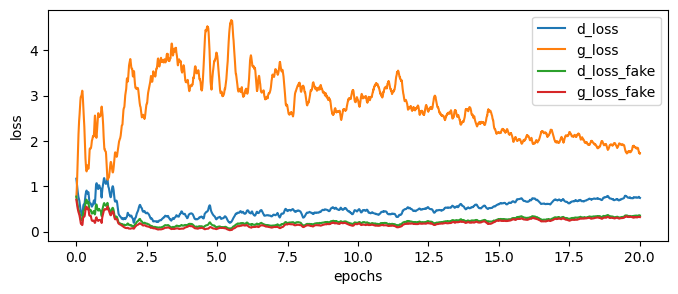

Epoch [21/200], Step[100/469], d_loss: 0.7461, d_loss_fake: 0.3434, g_loss: 2.1022, g_loss_fake: 0.3679, D(x): 0.78, D(G(z)): 0.23
Epoch [21/200], Step[200/469], d_loss: 0.7070, d_loss_fake: 0.2994, g_loss: 1.8700, g_loss_fake: 0.3150, D(x): 0.76, D(G(z)): 0.22
Epoch [21/200], Step[300/469], d_loss: 0.8953, d_loss_fake: 0.2894, g_loss: 1.6062, g_loss_fake: 0.3177, D(x): 0.63, D(G(z)): 0.23
Epoch [21/200], Step[400/469], d_loss: 0.8693, d_loss_fake: 0.4423, g_loss: 1.5442, g_loss_fake: 0.3845, D(x): 0.75, D(G(z)): 0.30
Epoch [22/200], Step[100/469], d_loss: 0.8972, d_loss_fake: 0.3944, g_loss: 1.6120, g_loss_fake: 0.3890, D(x): 0.73, D(G(z)): 0.26
Epoch [22/200], Step[200/469], d_loss: 0.8610, d_loss_fake: 0.3748, g_loss: 1.5787, g_loss_fake: 0.3307, D(x): 0.71, D(G(z)): 0.27
Epoch [22/200], Step[300/469], d_loss: 0.8647, d_loss_fake: 0.3494, g_loss: 1.7808, g_loss_fake: 0.2865, D(x): 0.70, D(G(z)): 0.26
Epoch [22/200], Step[400/469], d_loss: 0.8071, d_loss_fake: 0.3047, g_loss: 1.8075,

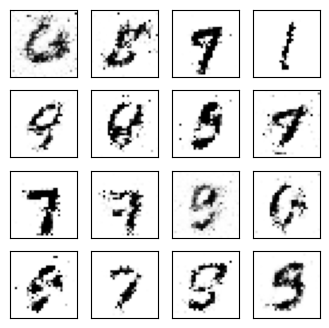

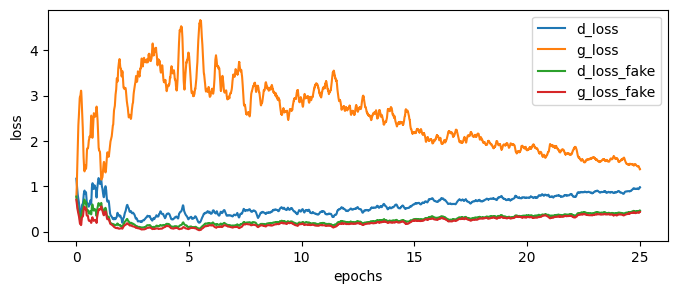

Epoch [26/200], Step[100/469], d_loss: 0.9262, d_loss_fake: 0.5497, g_loss: 1.3564, g_loss_fake: 0.4216, D(x): 0.75, D(G(z)): 0.35
Epoch [26/200], Step[200/469], d_loss: 0.9794, d_loss_fake: 0.5330, g_loss: 1.3755, g_loss_fake: 0.4468, D(x): 0.71, D(G(z)): 0.34
Epoch [26/200], Step[300/469], d_loss: 0.8659, d_loss_fake: 0.4910, g_loss: 1.1584, g_loss_fake: 0.5257, D(x): 0.73, D(G(z)): 0.35
Epoch [26/200], Step[400/469], d_loss: 1.0328, d_loss_fake: 0.4005, g_loss: 1.4337, g_loss_fake: 0.4288, D(x): 0.64, D(G(z)): 0.27
Epoch [27/200], Step[100/469], d_loss: 0.8618, d_loss_fake: 0.4238, g_loss: 1.4629, g_loss_fake: 0.4346, D(x): 0.72, D(G(z)): 0.30
Epoch [27/200], Step[200/469], d_loss: 1.0008, d_loss_fake: 0.4556, g_loss: 1.4079, g_loss_fake: 0.4881, D(x): 0.69, D(G(z)): 0.30
Epoch [27/200], Step[300/469], d_loss: 1.0106, d_loss_fake: 0.4642, g_loss: 1.7005, g_loss_fake: 0.2977, D(x): 0.67, D(G(z)): 0.31
Epoch [27/200], Step[400/469], d_loss: 1.0305, d_loss_fake: 0.4012, g_loss: 1.5719,

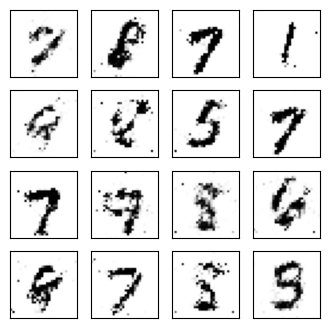

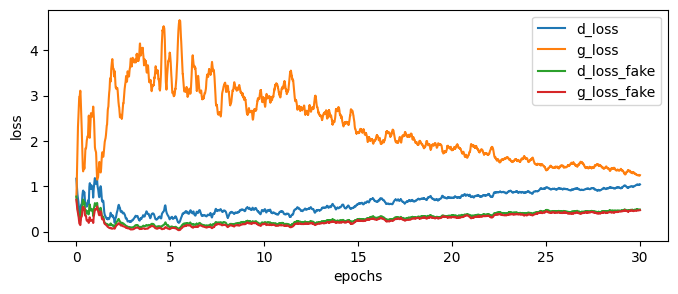

Epoch [31/200], Step[100/469], d_loss: 1.0019, d_loss_fake: 0.5433, g_loss: 1.2815, g_loss_fake: 0.4405, D(x): 0.71, D(G(z)): 0.36
Epoch [31/200], Step[200/469], d_loss: 1.0647, d_loss_fake: 0.5231, g_loss: 1.1445, g_loss_fake: 0.5624, D(x): 0.66, D(G(z)): 0.37
Epoch [31/200], Step[300/469], d_loss: 0.9694, d_loss_fake: 0.4932, g_loss: 1.1579, g_loss_fake: 0.5085, D(x): 0.68, D(G(z)): 0.35
Epoch [31/200], Step[400/469], d_loss: 1.0420, d_loss_fake: 0.5516, g_loss: 1.1945, g_loss_fake: 0.5373, D(x): 0.68, D(G(z)): 0.38
Epoch [32/200], Step[100/469], d_loss: 1.1163, d_loss_fake: 0.4887, g_loss: 1.1682, g_loss_fake: 0.4916, D(x): 0.59, D(G(z)): 0.35
Epoch [32/200], Step[200/469], d_loss: 0.9620, d_loss_fake: 0.5146, g_loss: 1.0695, g_loss_fake: 0.5131, D(x): 0.69, D(G(z)): 0.37
Epoch [32/200], Step[300/469], d_loss: 1.2146, d_loss_fake: 0.5374, g_loss: 1.2231, g_loss_fake: 0.4644, D(x): 0.59, D(G(z)): 0.36
Epoch [32/200], Step[400/469], d_loss: 1.0461, d_loss_fake: 0.5131, g_loss: 1.2562,

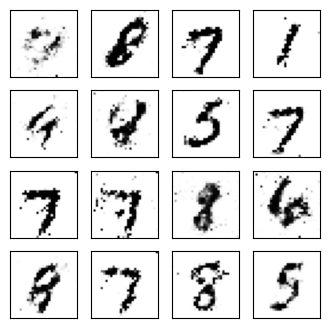

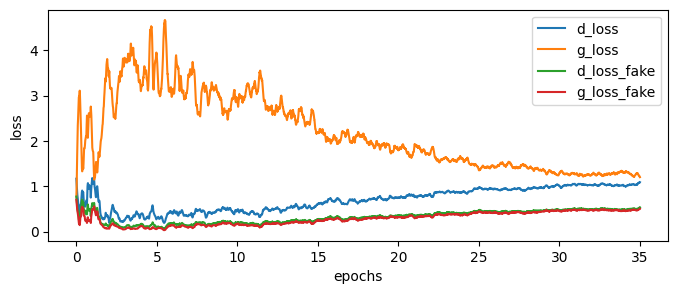

Epoch [36/200], Step[100/469], d_loss: 0.9613, d_loss_fake: 0.5092, g_loss: 0.9977, g_loss_fake: 0.5510, D(x): 0.68, D(G(z)): 0.36
Epoch [36/200], Step[200/469], d_loss: 1.1374, d_loss_fake: 0.6091, g_loss: 1.0129, g_loss_fake: 0.6013, D(x): 0.65, D(G(z)): 0.42
Epoch [36/200], Step[300/469], d_loss: 1.0999, d_loss_fake: 0.5135, g_loss: 1.1680, g_loss_fake: 0.5305, D(x): 0.63, D(G(z)): 0.36
Epoch [36/200], Step[400/469], d_loss: 1.0770, d_loss_fake: 0.5592, g_loss: 1.0568, g_loss_fake: 0.5480, D(x): 0.66, D(G(z)): 0.39
Epoch [37/200], Step[100/469], d_loss: 1.0465, d_loss_fake: 0.5637, g_loss: 1.1329, g_loss_fake: 0.5399, D(x): 0.68, D(G(z)): 0.38
Epoch [37/200], Step[200/469], d_loss: 1.0894, d_loss_fake: 0.5045, g_loss: 1.1808, g_loss_fake: 0.5002, D(x): 0.61, D(G(z)): 0.36
Epoch [37/200], Step[300/469], d_loss: 1.1031, d_loss_fake: 0.5601, g_loss: 1.1225, g_loss_fake: 0.5357, D(x): 0.63, D(G(z)): 0.38
Epoch [37/200], Step[400/469], d_loss: 1.0786, d_loss_fake: 0.4882, g_loss: 1.1122,

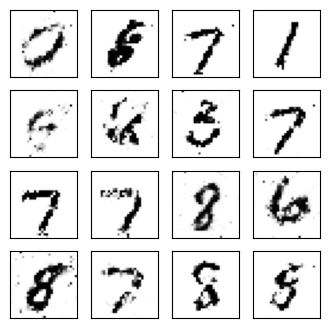

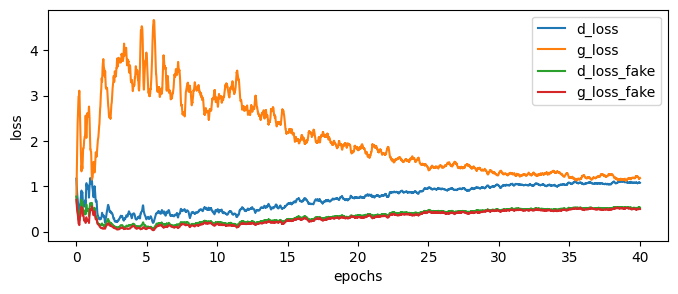

Epoch [41/200], Step[100/469], d_loss: 1.0089, d_loss_fake: 0.5010, g_loss: 1.1935, g_loss_fake: 0.5061, D(x): 0.66, D(G(z)): 0.35
Epoch [41/200], Step[200/469], d_loss: 1.0091, d_loss_fake: 0.5158, g_loss: 1.1839, g_loss_fake: 0.4957, D(x): 0.67, D(G(z)): 0.36
Epoch [41/200], Step[300/469], d_loss: 1.1680, d_loss_fake: 0.6448, g_loss: 1.0467, g_loss_fake: 0.6435, D(x): 0.65, D(G(z)): 0.43
Epoch [41/200], Step[400/469], d_loss: 1.1654, d_loss_fake: 0.7292, g_loss: 0.8703, g_loss_fake: 0.7062, D(x): 0.69, D(G(z)): 0.48
Epoch [42/200], Step[100/469], d_loss: 1.1361, d_loss_fake: 0.5167, g_loss: 1.2073, g_loss_fake: 0.4615, D(x): 0.60, D(G(z)): 0.36
Epoch [42/200], Step[200/469], d_loss: 1.0133, d_loss_fake: 0.4303, g_loss: 1.2867, g_loss_fake: 0.4401, D(x): 0.62, D(G(z)): 0.31
Epoch [42/200], Step[300/469], d_loss: 1.0334, d_loss_fake: 0.5347, g_loss: 1.1182, g_loss_fake: 0.5714, D(x): 0.65, D(G(z)): 0.38
Epoch [42/200], Step[400/469], d_loss: 1.1405, d_loss_fake: 0.6401, g_loss: 1.0886,

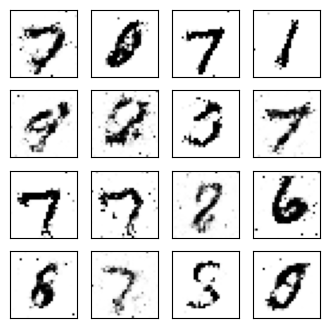

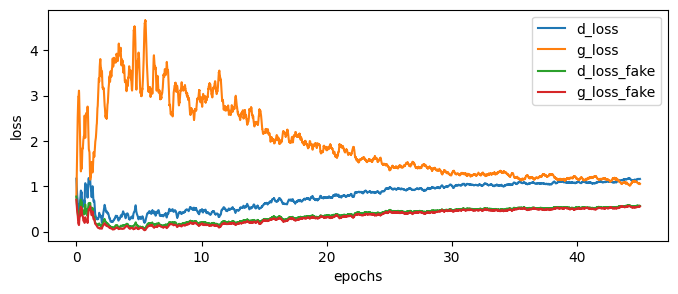

Epoch [46/200], Step[100/469], d_loss: 1.1371, d_loss_fake: 0.5334, g_loss: 0.9952, g_loss_fake: 0.5746, D(x): 0.60, D(G(z)): 0.39
Epoch [46/200], Step[200/469], d_loss: 1.1361, d_loss_fake: 0.5629, g_loss: 1.0957, g_loss_fake: 0.4929, D(x): 0.61, D(G(z)): 0.39
Epoch [46/200], Step[300/469], d_loss: 1.1535, d_loss_fake: 0.6406, g_loss: 0.9553, g_loss_fake: 0.6378, D(x): 0.65, D(G(z)): 0.43
Epoch [46/200], Step[400/469], d_loss: 1.2157, d_loss_fake: 0.5714, g_loss: 1.0019, g_loss_fake: 0.5655, D(x): 0.58, D(G(z)): 0.40
Epoch [47/200], Step[100/469], d_loss: 1.0931, d_loss_fake: 0.5404, g_loss: 1.0288, g_loss_fake: 0.6135, D(x): 0.62, D(G(z)): 0.38
Epoch [47/200], Step[200/469], d_loss: 1.1481, d_loss_fake: 0.6498, g_loss: 1.1338, g_loss_fake: 0.5100, D(x): 0.65, D(G(z)): 0.42
Epoch [47/200], Step[300/469], d_loss: 1.1485, d_loss_fake: 0.5660, g_loss: 0.9673, g_loss_fake: 0.6244, D(x): 0.60, D(G(z)): 0.41
Epoch [47/200], Step[400/469], d_loss: 1.1060, d_loss_fake: 0.5163, g_loss: 1.0618,

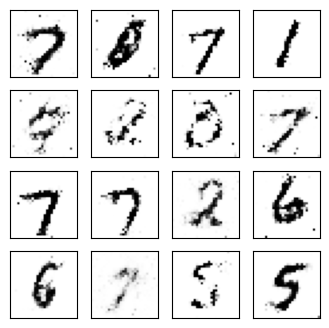

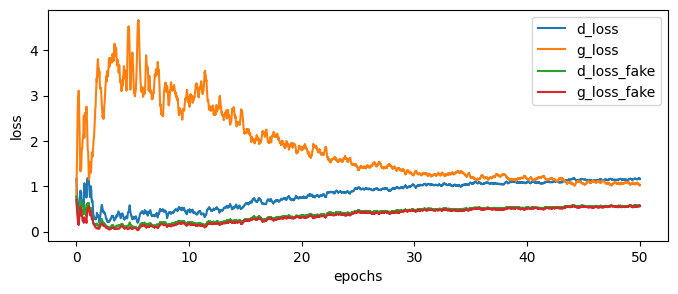

Epoch [51/200], Step[100/469], d_loss: 1.2750, d_loss_fake: 0.5938, g_loss: 1.0146, g_loss_fake: 0.5899, D(x): 0.55, D(G(z)): 0.41
Epoch [51/200], Step[200/469], d_loss: 1.1265, d_loss_fake: 0.5255, g_loss: 1.1586, g_loss_fake: 0.4967, D(x): 0.59, D(G(z)): 0.38
Epoch [51/200], Step[300/469], d_loss: 1.1605, d_loss_fake: 0.6075, g_loss: 0.9635, g_loss_fake: 0.5875, D(x): 0.62, D(G(z)): 0.43
Epoch [51/200], Step[400/469], d_loss: 1.1444, d_loss_fake: 0.4980, g_loss: 1.1185, g_loss_fake: 0.5182, D(x): 0.57, D(G(z)): 0.37
Epoch [52/200], Step[100/469], d_loss: 1.1947, d_loss_fake: 0.6234, g_loss: 1.0237, g_loss_fake: 0.5262, D(x): 0.60, D(G(z)): 0.43
Epoch [52/200], Step[200/469], d_loss: 1.1511, d_loss_fake: 0.5240, g_loss: 1.0401, g_loss_fake: 0.5405, D(x): 0.57, D(G(z)): 0.38
Epoch [52/200], Step[300/469], d_loss: 1.2676, d_loss_fake: 0.6476, g_loss: 1.0982, g_loss_fake: 0.5091, D(x): 0.59, D(G(z)): 0.44
Epoch [52/200], Step[400/469], d_loss: 1.1348, d_loss_fake: 0.5537, g_loss: 0.8779,

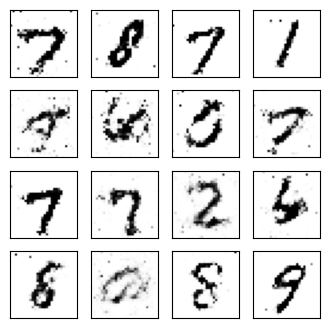

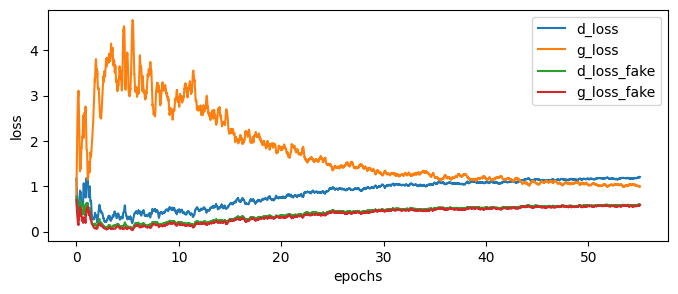

Epoch [56/200], Step[100/469], d_loss: 1.2071, d_loss_fake: 0.5660, g_loss: 1.0613, g_loss_fake: 0.5126, D(x): 0.59, D(G(z)): 0.40
Epoch [56/200], Step[200/469], d_loss: 1.1626, d_loss_fake: 0.5234, g_loss: 1.0566, g_loss_fake: 0.5295, D(x): 0.57, D(G(z)): 0.38
Epoch [56/200], Step[300/469], d_loss: 1.2119, d_loss_fake: 0.5928, g_loss: 0.9175, g_loss_fake: 0.5957, D(x): 0.57, D(G(z)): 0.41
Epoch [56/200], Step[400/469], d_loss: 1.1935, d_loss_fake: 0.6145, g_loss: 0.9291, g_loss_fake: 0.6439, D(x): 0.60, D(G(z)): 0.44
Epoch [57/200], Step[100/469], d_loss: 1.1587, d_loss_fake: 0.6071, g_loss: 0.9564, g_loss_fake: 0.6032, D(x): 0.61, D(G(z)): 0.42
Epoch [57/200], Step[200/469], d_loss: 1.1630, d_loss_fake: 0.5568, g_loss: 1.0620, g_loss_fake: 0.5181, D(x): 0.59, D(G(z)): 0.40
Epoch [57/200], Step[300/469], d_loss: 1.1865, d_loss_fake: 0.5128, g_loss: 1.0488, g_loss_fake: 0.5631, D(x): 0.55, D(G(z)): 0.38
Epoch [57/200], Step[400/469], d_loss: 1.1971, d_loss_fake: 0.5447, g_loss: 0.9720,

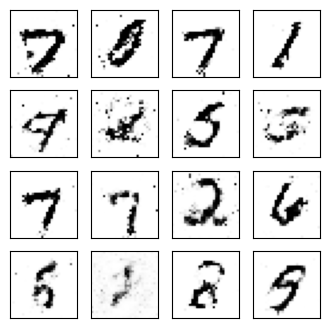

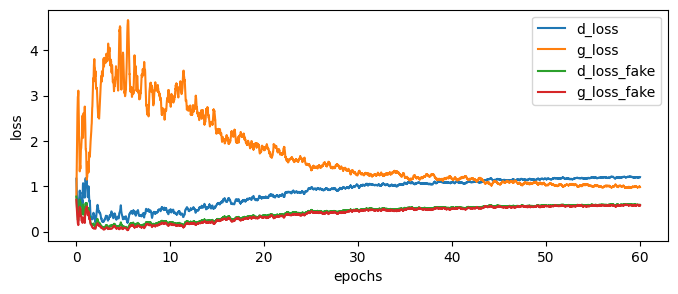

Epoch [61/200], Step[100/469], d_loss: 1.2494, d_loss_fake: 0.6117, g_loss: 0.9597, g_loss_fake: 0.5956, D(x): 0.58, D(G(z)): 0.43
Epoch [61/200], Step[200/469], d_loss: 1.2470, d_loss_fake: 0.5517, g_loss: 1.0075, g_loss_fake: 0.5696, D(x): 0.54, D(G(z)): 0.39
Epoch [61/200], Step[300/469], d_loss: 1.1683, d_loss_fake: 0.5812, g_loss: 0.9849, g_loss_fake: 0.5983, D(x): 0.59, D(G(z)): 0.41
Epoch [61/200], Step[400/469], d_loss: 1.1001, d_loss_fake: 0.5237, g_loss: 1.0142, g_loss_fake: 0.5777, D(x): 0.60, D(G(z)): 0.39
Epoch [62/200], Step[100/469], d_loss: 1.2437, d_loss_fake: 0.5539, g_loss: 1.0152, g_loss_fake: 0.5931, D(x): 0.54, D(G(z)): 0.39
Epoch [62/200], Step[200/469], d_loss: 1.1101, d_loss_fake: 0.5684, g_loss: 0.9697, g_loss_fake: 0.6049, D(x): 0.62, D(G(z)): 0.39
Epoch [62/200], Step[300/469], d_loss: 1.1624, d_loss_fake: 0.6338, g_loss: 0.9440, g_loss_fake: 0.6043, D(x): 0.63, D(G(z)): 0.44
Epoch [62/200], Step[400/469], d_loss: 1.1658, d_loss_fake: 0.6241, g_loss: 1.0814,

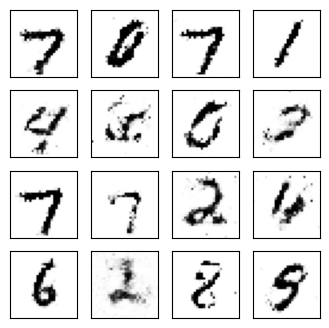

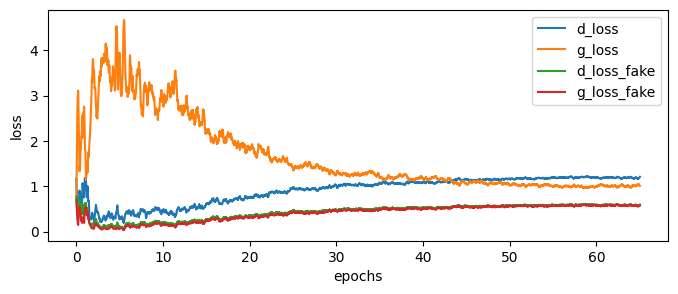

Epoch [66/200], Step[100/469], d_loss: 1.2271, d_loss_fake: 0.5804, g_loss: 1.0483, g_loss_fake: 0.5874, D(x): 0.57, D(G(z)): 0.41
Epoch [66/200], Step[200/469], d_loss: 1.1876, d_loss_fake: 0.5948, g_loss: 1.0144, g_loss_fake: 0.5742, D(x): 0.59, D(G(z)): 0.41
Epoch [66/200], Step[300/469], d_loss: 1.1808, d_loss_fake: 0.5482, g_loss: 1.0844, g_loss_fake: 0.5192, D(x): 0.58, D(G(z)): 0.39
Epoch [66/200], Step[400/469], d_loss: 1.1620, d_loss_fake: 0.5509, g_loss: 0.9815, g_loss_fake: 0.5952, D(x): 0.59, D(G(z)): 0.40
Epoch [67/200], Step[100/469], d_loss: 1.2407, d_loss_fake: 0.5958, g_loss: 0.9780, g_loss_fake: 0.5956, D(x): 0.57, D(G(z)): 0.41
Epoch [67/200], Step[200/469], d_loss: 1.2111, d_loss_fake: 0.5692, g_loss: 0.8958, g_loss_fake: 0.6435, D(x): 0.56, D(G(z)): 0.41
Epoch [67/200], Step[300/469], d_loss: 1.1866, d_loss_fake: 0.6379, g_loss: 0.9979, g_loss_fake: 0.5566, D(x): 0.62, D(G(z)): 0.44
Epoch [67/200], Step[400/469], d_loss: 1.2352, d_loss_fake: 0.5630, g_loss: 1.0915,

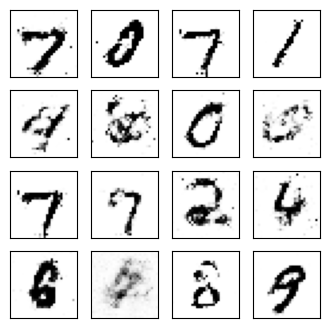

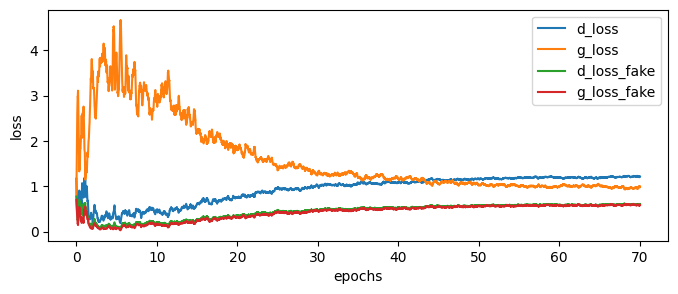

Epoch [71/200], Step[100/469], d_loss: 1.2054, d_loss_fake: 0.6068, g_loss: 0.9654, g_loss_fake: 0.5949, D(x): 0.59, D(G(z)): 0.42
Epoch [71/200], Step[200/469], d_loss: 1.2632, d_loss_fake: 0.6394, g_loss: 1.0253, g_loss_fake: 0.5311, D(x): 0.58, D(G(z)): 0.43
Epoch [71/200], Step[300/469], d_loss: 1.1838, d_loss_fake: 0.5320, g_loss: 0.8953, g_loss_fake: 0.6216, D(x): 0.55, D(G(z)): 0.39
Epoch [71/200], Step[400/469], d_loss: 1.2611, d_loss_fake: 0.4569, g_loss: 1.1491, g_loss_fake: 0.5269, D(x): 0.50, D(G(z)): 0.33
Epoch [72/200], Step[100/469], d_loss: 1.3572, d_loss_fake: 0.6872, g_loss: 1.0049, g_loss_fake: 0.5696, D(x): 0.57, D(G(z)): 0.45
Epoch [72/200], Step[200/469], d_loss: 1.2170, d_loss_fake: 0.5706, g_loss: 0.9980, g_loss_fake: 0.5540, D(x): 0.57, D(G(z)): 0.41
Epoch [72/200], Step[300/469], d_loss: 1.2900, d_loss_fake: 0.5934, g_loss: 1.0097, g_loss_fake: 0.5518, D(x): 0.53, D(G(z)): 0.40
Epoch [72/200], Step[400/469], d_loss: 1.2723, d_loss_fake: 0.6143, g_loss: 1.0160,

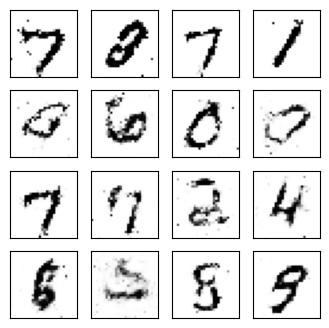

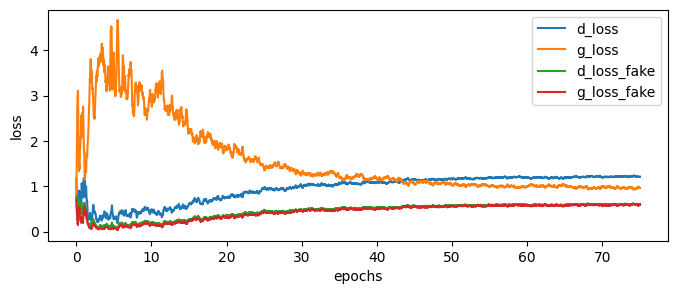

Epoch [76/200], Step[100/469], d_loss: 1.1838, d_loss_fake: 0.6280, g_loss: 0.8846, g_loss_fake: 0.6402, D(x): 0.61, D(G(z)): 0.44
Epoch [76/200], Step[200/469], d_loss: 1.2241, d_loss_fake: 0.5797, g_loss: 1.0524, g_loss_fake: 0.5417, D(x): 0.56, D(G(z)): 0.41
Epoch [76/200], Step[300/469], d_loss: 1.1851, d_loss_fake: 0.6642, g_loss: 0.9128, g_loss_fake: 0.5941, D(x): 0.63, D(G(z)): 0.45
Epoch [76/200], Step[400/469], d_loss: 1.1656, d_loss_fake: 0.5232, g_loss: 0.9898, g_loss_fake: 0.5523, D(x): 0.55, D(G(z)): 0.39
Epoch [77/200], Step[100/469], d_loss: 1.2582, d_loss_fake: 0.7068, g_loss: 0.8489, g_loss_fake: 0.6699, D(x): 0.60, D(G(z)): 0.48
Epoch [77/200], Step[200/469], d_loss: 1.2138, d_loss_fake: 0.5639, g_loss: 1.0334, g_loss_fake: 0.5236, D(x): 0.56, D(G(z)): 0.41
Epoch [77/200], Step[300/469], d_loss: 1.1737, d_loss_fake: 0.5350, g_loss: 0.9456, g_loss_fake: 0.6002, D(x): 0.56, D(G(z)): 0.40
Epoch [77/200], Step[400/469], d_loss: 1.2100, d_loss_fake: 0.5864, g_loss: 1.0761,

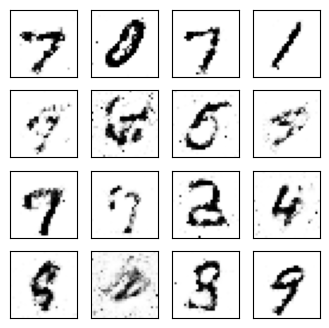

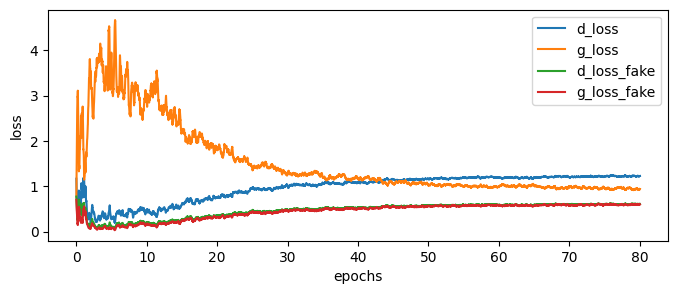

Epoch [81/200], Step[100/469], d_loss: 1.1592, d_loss_fake: 0.6222, g_loss: 0.9759, g_loss_fake: 0.6158, D(x): 0.62, D(G(z)): 0.43
Epoch [81/200], Step[200/469], d_loss: 1.2252, d_loss_fake: 0.6293, g_loss: 0.8914, g_loss_fake: 0.6426, D(x): 0.59, D(G(z)): 0.45
Epoch [81/200], Step[300/469], d_loss: 1.2361, d_loss_fake: 0.5992, g_loss: 0.8739, g_loss_fake: 0.6904, D(x): 0.56, D(G(z)): 0.43
Epoch [81/200], Step[400/469], d_loss: 1.2143, d_loss_fake: 0.5199, g_loss: 0.9379, g_loss_fake: 0.6126, D(x): 0.54, D(G(z)): 0.38
Epoch [82/200], Step[100/469], d_loss: 1.2329, d_loss_fake: 0.5734, g_loss: 0.9544, g_loss_fake: 0.5778, D(x): 0.55, D(G(z)): 0.42
Epoch [82/200], Step[200/469], d_loss: 1.2462, d_loss_fake: 0.6105, g_loss: 0.9276, g_loss_fake: 0.6082, D(x): 0.56, D(G(z)): 0.43
Epoch [82/200], Step[300/469], d_loss: 1.2424, d_loss_fake: 0.6796, g_loss: 0.9252, g_loss_fake: 0.5944, D(x): 0.60, D(G(z)): 0.46
Epoch [82/200], Step[400/469], d_loss: 1.2109, d_loss_fake: 0.6459, g_loss: 0.9202,

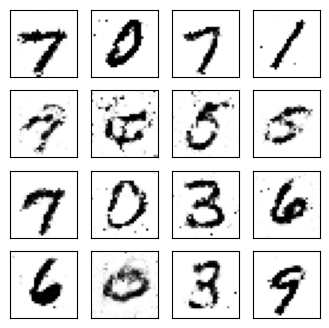

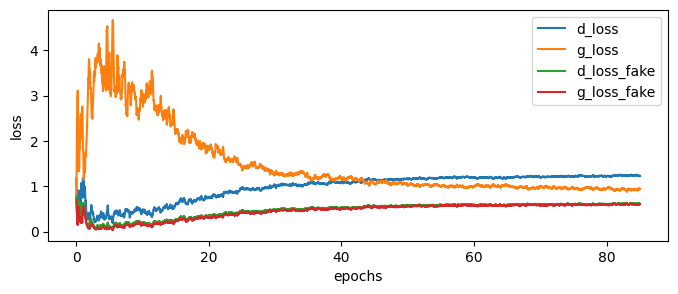

Epoch [86/200], Step[100/469], d_loss: 1.1984, d_loss_fake: 0.6460, g_loss: 0.8823, g_loss_fake: 0.6083, D(x): 0.61, D(G(z)): 0.45
Epoch [86/200], Step[200/469], d_loss: 1.2762, d_loss_fake: 0.6728, g_loss: 0.8894, g_loss_fake: 0.6521, D(x): 0.57, D(G(z)): 0.46
Epoch [86/200], Step[300/469], d_loss: 1.2417, d_loss_fake: 0.6081, g_loss: 0.8653, g_loss_fake: 0.6082, D(x): 0.56, D(G(z)): 0.44
Epoch [86/200], Step[400/469], d_loss: 1.1537, d_loss_fake: 0.5381, g_loss: 0.9947, g_loss_fake: 0.5633, D(x): 0.57, D(G(z)): 0.40
Epoch [87/200], Step[100/469], d_loss: 1.1824, d_loss_fake: 0.5790, g_loss: 0.9499, g_loss_fake: 0.6113, D(x): 0.58, D(G(z)): 0.42
Epoch [87/200], Step[200/469], d_loss: 1.1844, d_loss_fake: 0.5501, g_loss: 0.9452, g_loss_fake: 0.6019, D(x): 0.56, D(G(z)): 0.40
Epoch [87/200], Step[300/469], d_loss: 1.2885, d_loss_fake: 0.6571, g_loss: 0.9559, g_loss_fake: 0.5823, D(x): 0.57, D(G(z)): 0.44
Epoch [87/200], Step[400/469], d_loss: 1.2181, d_loss_fake: 0.5305, g_loss: 0.9493,

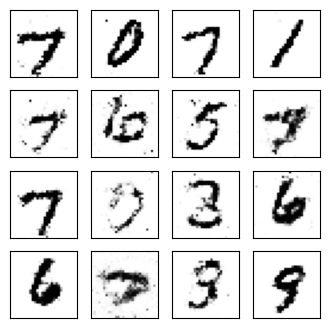

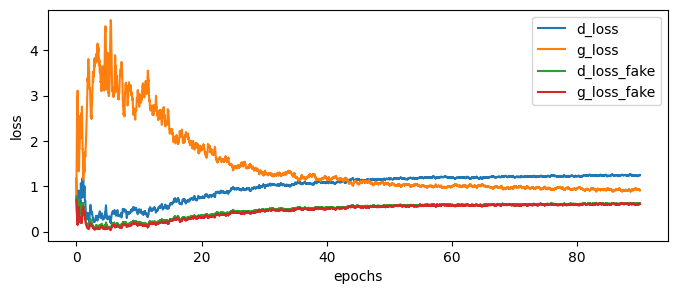

Epoch [91/200], Step[100/469], d_loss: 1.3438, d_loss_fake: 0.6635, g_loss: 0.8168, g_loss_fake: 0.6781, D(x): 0.54, D(G(z)): 0.46
Epoch [91/200], Step[200/469], d_loss: 1.2000, d_loss_fake: 0.6246, g_loss: 1.0171, g_loss_fake: 0.5753, D(x): 0.59, D(G(z)): 0.44
Epoch [91/200], Step[300/469], d_loss: 1.2559, d_loss_fake: 0.6512, g_loss: 0.9041, g_loss_fake: 0.6026, D(x): 0.58, D(G(z)): 0.45
Epoch [91/200], Step[400/469], d_loss: 1.2247, d_loss_fake: 0.5726, g_loss: 0.9830, g_loss_fake: 0.5868, D(x): 0.55, D(G(z)): 0.40
Epoch [92/200], Step[100/469], d_loss: 1.2723, d_loss_fake: 0.6339, g_loss: 0.9153, g_loss_fake: 0.6461, D(x): 0.56, D(G(z)): 0.44
Epoch [92/200], Step[200/469], d_loss: 1.2367, d_loss_fake: 0.6587, g_loss: 0.8588, g_loss_fake: 0.6693, D(x): 0.60, D(G(z)): 0.45
Epoch [92/200], Step[300/469], d_loss: 1.2388, d_loss_fake: 0.5632, g_loss: 0.9313, g_loss_fake: 0.6020, D(x): 0.56, D(G(z)): 0.41
Epoch [92/200], Step[400/469], d_loss: 1.2582, d_loss_fake: 0.6333, g_loss: 0.9187,

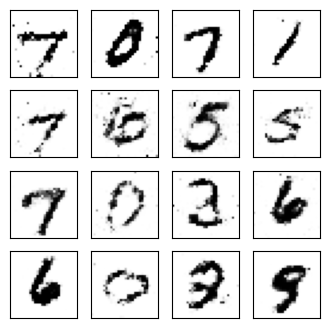

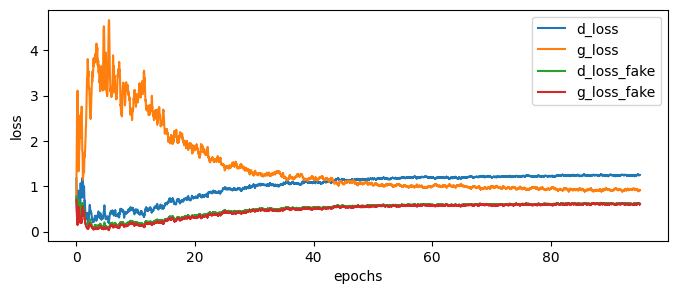

Epoch [96/200], Step[100/469], d_loss: 1.1835, d_loss_fake: 0.6111, g_loss: 0.9478, g_loss_fake: 0.5571, D(x): 0.59, D(G(z)): 0.43
Epoch [96/200], Step[200/469], d_loss: 1.2609, d_loss_fake: 0.6473, g_loss: 0.9707, g_loss_fake: 0.5693, D(x): 0.57, D(G(z)): 0.45
Epoch [96/200], Step[300/469], d_loss: 1.2938, d_loss_fake: 0.6221, g_loss: 0.9242, g_loss_fake: 0.5894, D(x): 0.54, D(G(z)): 0.43
Epoch [96/200], Step[400/469], d_loss: 1.2166, d_loss_fake: 0.6530, g_loss: 0.7845, g_loss_fake: 0.7070, D(x): 0.60, D(G(z)): 0.45
Epoch [97/200], Step[100/469], d_loss: 1.3003, d_loss_fake: 0.6471, g_loss: 0.9365, g_loss_fake: 0.5702, D(x): 0.55, D(G(z)): 0.45
Epoch [97/200], Step[200/469], d_loss: 1.2377, d_loss_fake: 0.7183, g_loss: 0.7647, g_loss_fake: 0.7135, D(x): 0.62, D(G(z)): 0.49
Epoch [97/200], Step[300/469], d_loss: 1.1941, d_loss_fake: 0.5716, g_loss: 0.9059, g_loss_fake: 0.5869, D(x): 0.56, D(G(z)): 0.42
Epoch [97/200], Step[400/469], d_loss: 1.1918, d_loss_fake: 0.5284, g_loss: 1.0334,

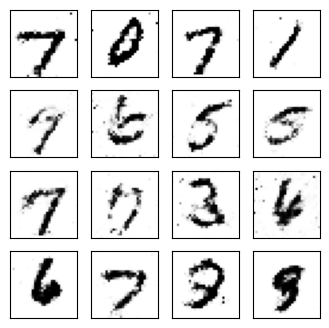

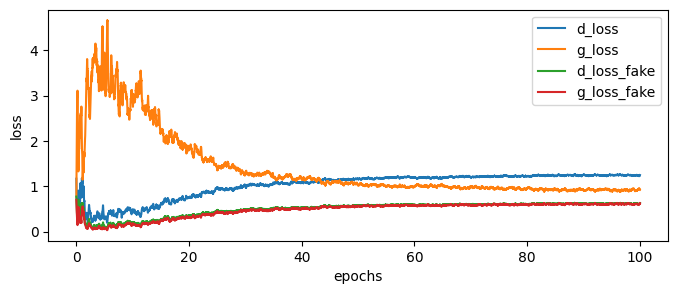

Epoch [101/200], Step[100/469], d_loss: 1.3108, d_loss_fake: 0.6931, g_loss: 0.8612, g_loss_fake: 0.6740, D(x): 0.57, D(G(z)): 0.46
Epoch [101/200], Step[200/469], d_loss: 1.2563, d_loss_fake: 0.6350, g_loss: 0.8138, g_loss_fake: 0.6827, D(x): 0.57, D(G(z)): 0.45
Epoch [101/200], Step[300/469], d_loss: 1.2178, d_loss_fake: 0.5925, g_loss: 0.8743, g_loss_fake: 0.6128, D(x): 0.56, D(G(z)): 0.43
Epoch [101/200], Step[400/469], d_loss: 1.2320, d_loss_fake: 0.6921, g_loss: 0.8303, g_loss_fake: 0.6588, D(x): 0.61, D(G(z)): 0.47
Epoch [102/200], Step[100/469], d_loss: 1.2408, d_loss_fake: 0.6255, g_loss: 0.8993, g_loss_fake: 0.6179, D(x): 0.57, D(G(z)): 0.44
Epoch [102/200], Step[200/469], d_loss: 1.2343, d_loss_fake: 0.6390, g_loss: 0.8231, g_loss_fake: 0.6908, D(x): 0.58, D(G(z)): 0.45
Epoch [102/200], Step[300/469], d_loss: 1.2705, d_loss_fake: 0.5954, g_loss: 0.8884, g_loss_fake: 0.6367, D(x): 0.54, D(G(z)): 0.43
Epoch [102/200], Step[400/469], d_loss: 1.2104, d_loss_fake: 0.5790, g_loss:

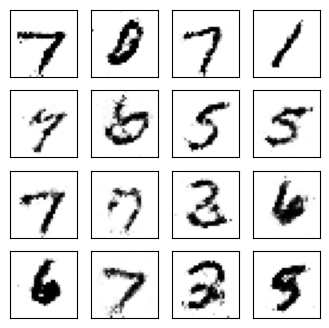

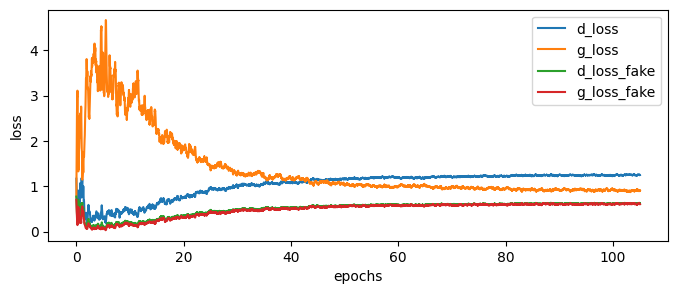

Epoch [106/200], Step[100/469], d_loss: 1.2916, d_loss_fake: 0.6263, g_loss: 0.8970, g_loss_fake: 0.6038, D(x): 0.54, D(G(z)): 0.43
Epoch [106/200], Step[200/469], d_loss: 1.1788, d_loss_fake: 0.5410, g_loss: 0.9990, g_loss_fake: 0.5454, D(x): 0.55, D(G(z)): 0.40
Epoch [106/200], Step[300/469], d_loss: 1.2547, d_loss_fake: 0.6301, g_loss: 0.9139, g_loss_fake: 0.6064, D(x): 0.57, D(G(z)): 0.44
Epoch [106/200], Step[400/469], d_loss: 1.2638, d_loss_fake: 0.6267, g_loss: 0.9014, g_loss_fake: 0.6064, D(x): 0.56, D(G(z)): 0.44
Epoch [107/200], Step[100/469], d_loss: 1.2352, d_loss_fake: 0.5739, g_loss: 1.0492, g_loss_fake: 0.4939, D(x): 0.55, D(G(z)): 0.42
Epoch [107/200], Step[200/469], d_loss: 1.2706, d_loss_fake: 0.5872, g_loss: 0.9032, g_loss_fake: 0.6363, D(x): 0.54, D(G(z)): 0.42
Epoch [107/200], Step[300/469], d_loss: 1.2656, d_loss_fake: 0.5971, g_loss: 0.9454, g_loss_fake: 0.5825, D(x): 0.54, D(G(z)): 0.43
Epoch [107/200], Step[400/469], d_loss: 1.2741, d_loss_fake: 0.6653, g_loss:

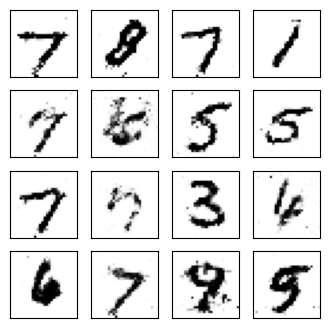

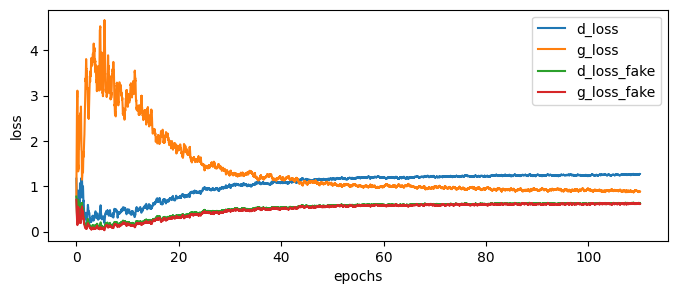

Epoch [111/200], Step[100/469], d_loss: 1.3124, d_loss_fake: 0.6901, g_loss: 0.7935, g_loss_fake: 0.7101, D(x): 0.56, D(G(z)): 0.48
Epoch [111/200], Step[200/469], d_loss: 1.2095, d_loss_fake: 0.6028, g_loss: 1.1264, g_loss_fake: 0.4862, D(x): 0.57, D(G(z)): 0.42
Epoch [111/200], Step[300/469], d_loss: 1.2433, d_loss_fake: 0.5715, g_loss: 1.0228, g_loss_fake: 0.5546, D(x): 0.54, D(G(z)): 0.41
Epoch [111/200], Step[400/469], d_loss: 1.2515, d_loss_fake: 0.5940, g_loss: 1.0295, g_loss_fake: 0.5479, D(x): 0.55, D(G(z)): 0.41
Epoch [112/200], Step[100/469], d_loss: 1.1878, d_loss_fake: 0.5619, g_loss: 0.9663, g_loss_fake: 0.5451, D(x): 0.57, D(G(z)): 0.41
Epoch [112/200], Step[200/469], d_loss: 1.1434, d_loss_fake: 0.5320, g_loss: 0.9212, g_loss_fake: 0.6079, D(x): 0.57, D(G(z)): 0.40
Epoch [112/200], Step[300/469], d_loss: 1.2492, d_loss_fake: 0.6220, g_loss: 0.8330, g_loss_fake: 0.6677, D(x): 0.56, D(G(z)): 0.44
Epoch [112/200], Step[400/469], d_loss: 1.2549, d_loss_fake: 0.5862, g_loss:

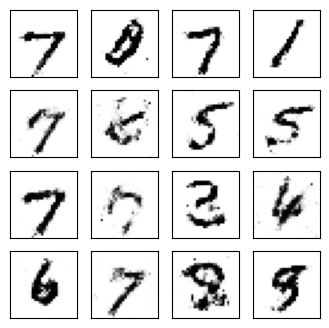

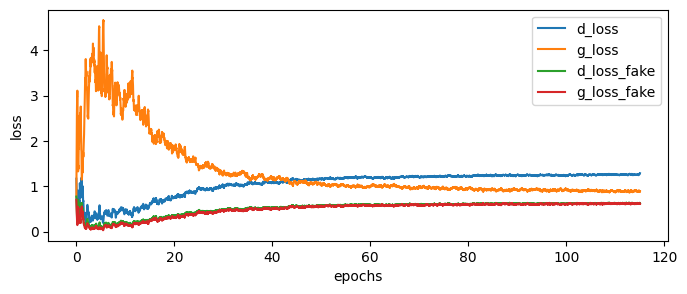

Epoch [116/200], Step[100/469], d_loss: 1.3180, d_loss_fake: 0.6674, g_loss: 0.8882, g_loss_fake: 0.6084, D(x): 0.55, D(G(z)): 0.46
Epoch [116/200], Step[200/469], d_loss: 1.3205, d_loss_fake: 0.7332, g_loss: 0.8195, g_loss_fake: 0.6785, D(x): 0.58, D(G(z)): 0.48
Epoch [116/200], Step[300/469], d_loss: 1.2637, d_loss_fake: 0.6517, g_loss: 0.8155, g_loss_fake: 0.6507, D(x): 0.57, D(G(z)): 0.46
Epoch [116/200], Step[400/469], d_loss: 1.3143, d_loss_fake: 0.6191, g_loss: 0.8346, g_loss_fake: 0.6396, D(x): 0.52, D(G(z)): 0.45
Epoch [117/200], Step[100/469], d_loss: 1.2633, d_loss_fake: 0.6219, g_loss: 0.8543, g_loss_fake: 0.6303, D(x): 0.55, D(G(z)): 0.43
Epoch [117/200], Step[200/469], d_loss: 1.1916, d_loss_fake: 0.5331, g_loss: 1.0136, g_loss_fake: 0.5430, D(x): 0.54, D(G(z)): 0.39
Epoch [117/200], Step[300/469], d_loss: 1.2130, d_loss_fake: 0.5832, g_loss: 0.9727, g_loss_fake: 0.5833, D(x): 0.56, D(G(z)): 0.42
Epoch [117/200], Step[400/469], d_loss: 1.2415, d_loss_fake: 0.6191, g_loss:

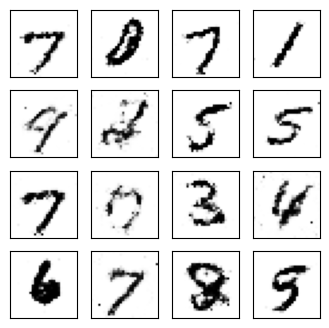

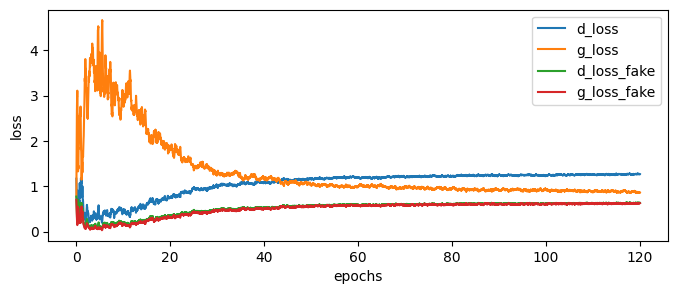

Epoch [121/200], Step[100/469], d_loss: 1.2698, d_loss_fake: 0.5583, g_loss: 0.9969, g_loss_fake: 0.5598, D(x): 0.52, D(G(z)): 0.41
Epoch [121/200], Step[200/469], d_loss: 1.2065, d_loss_fake: 0.5065, g_loss: 1.0306, g_loss_fake: 0.5043, D(x): 0.52, D(G(z)): 0.38
Epoch [121/200], Step[300/469], d_loss: 1.2705, d_loss_fake: 0.6784, g_loss: 0.8214, g_loss_fake: 0.6935, D(x): 0.58, D(G(z)): 0.47
Epoch [121/200], Step[400/469], d_loss: 1.3058, d_loss_fake: 0.6079, g_loss: 0.9459, g_loss_fake: 0.5525, D(x): 0.52, D(G(z)): 0.44
Epoch [122/200], Step[100/469], d_loss: 1.2604, d_loss_fake: 0.5921, g_loss: 0.9246, g_loss_fake: 0.5731, D(x): 0.54, D(G(z)): 0.43
Epoch [122/200], Step[200/469], d_loss: 1.2083, d_loss_fake: 0.6300, g_loss: 0.8115, g_loss_fake: 0.6875, D(x): 0.58, D(G(z)): 0.45
Epoch [122/200], Step[300/469], d_loss: 1.2371, d_loss_fake: 0.6184, g_loss: 0.8971, g_loss_fake: 0.6159, D(x): 0.57, D(G(z)): 0.44
Epoch [122/200], Step[400/469], d_loss: 1.2881, d_loss_fake: 0.5859, g_loss:

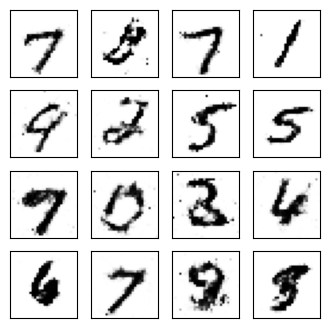

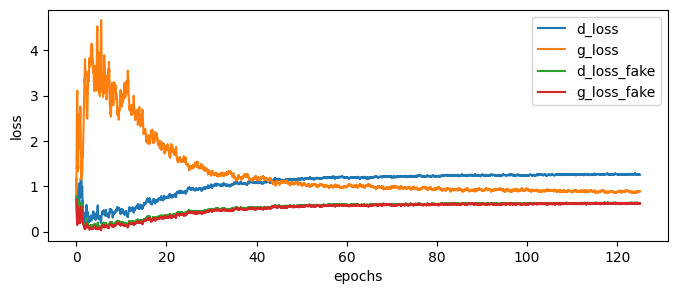

Epoch [126/200], Step[100/469], d_loss: 1.2111, d_loss_fake: 0.5854, g_loss: 0.8690, g_loss_fake: 0.6219, D(x): 0.56, D(G(z)): 0.43
Epoch [126/200], Step[200/469], d_loss: 1.2986, d_loss_fake: 0.7300, g_loss: 0.8117, g_loss_fake: 0.6475, D(x): 0.59, D(G(z)): 0.49
Epoch [126/200], Step[300/469], d_loss: 1.2978, d_loss_fake: 0.6174, g_loss: 0.8863, g_loss_fake: 0.6477, D(x): 0.54, D(G(z)): 0.44
Epoch [126/200], Step[400/469], d_loss: 1.3090, d_loss_fake: 0.7082, g_loss: 0.8075, g_loss_fake: 0.6579, D(x): 0.57, D(G(z)): 0.49
Epoch [127/200], Step[100/469], d_loss: 1.2997, d_loss_fake: 0.6499, g_loss: 0.9634, g_loss_fake: 0.5605, D(x): 0.55, D(G(z)): 0.45
Epoch [127/200], Step[200/469], d_loss: 1.3345, d_loss_fake: 0.6167, g_loss: 0.9645, g_loss_fake: 0.5888, D(x): 0.52, D(G(z)): 0.43
Epoch [127/200], Step[300/469], d_loss: 1.2457, d_loss_fake: 0.6135, g_loss: 0.8418, g_loss_fake: 0.6613, D(x): 0.56, D(G(z)): 0.43
Epoch [127/200], Step[400/469], d_loss: 1.2804, d_loss_fake: 0.6348, g_loss:

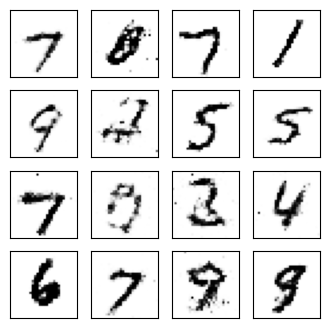

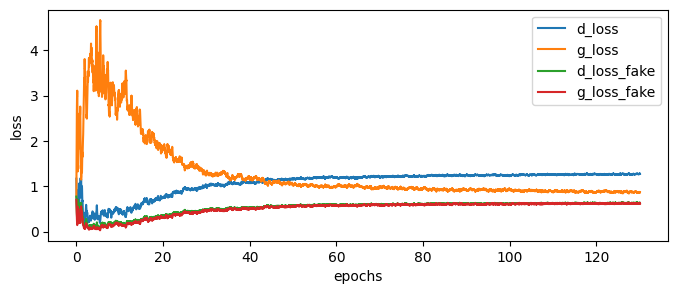

Epoch [131/200], Step[100/469], d_loss: 1.2012, d_loss_fake: 0.6003, g_loss: 0.8183, g_loss_fake: 0.6574, D(x): 0.57, D(G(z)): 0.43
Epoch [131/200], Step[200/469], d_loss: 1.3169, d_loss_fake: 0.5708, g_loss: 0.8866, g_loss_fake: 0.5949, D(x): 0.50, D(G(z)): 0.42
Epoch [131/200], Step[300/469], d_loss: 1.2835, d_loss_fake: 0.5776, g_loss: 0.9181, g_loss_fake: 0.5710, D(x): 0.52, D(G(z)): 0.42
Epoch [131/200], Step[400/469], d_loss: 1.2615, d_loss_fake: 0.6974, g_loss: 0.7898, g_loss_fake: 0.6730, D(x): 0.59, D(G(z)): 0.48
Epoch [132/200], Step[100/469], d_loss: 1.3153, d_loss_fake: 0.6347, g_loss: 0.9578, g_loss_fake: 0.5569, D(x): 0.53, D(G(z)): 0.45
Epoch [132/200], Step[200/469], d_loss: 1.2781, d_loss_fake: 0.5890, g_loss: 0.9706, g_loss_fake: 0.5881, D(x): 0.53, D(G(z)): 0.42
Epoch [132/200], Step[300/469], d_loss: 1.3165, d_loss_fake: 0.6825, g_loss: 0.8031, g_loss_fake: 0.7353, D(x): 0.57, D(G(z)): 0.46
Epoch [132/200], Step[400/469], d_loss: 1.3111, d_loss_fake: 0.6597, g_loss:

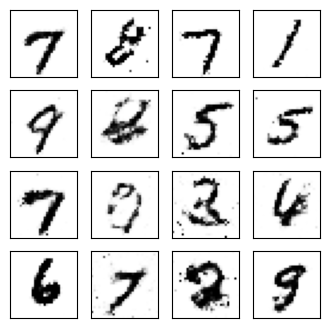

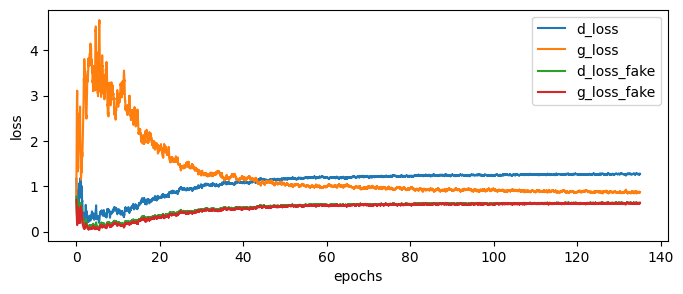

Epoch [136/200], Step[100/469], d_loss: 1.3191, d_loss_fake: 0.6653, g_loss: 0.9938, g_loss_fake: 0.5366, D(x): 0.54, D(G(z)): 0.46
Epoch [136/200], Step[200/469], d_loss: 1.3122, d_loss_fake: 0.6699, g_loss: 0.8791, g_loss_fake: 0.6175, D(x): 0.55, D(G(z)): 0.47
Epoch [136/200], Step[300/469], d_loss: 1.3211, d_loss_fake: 0.5710, g_loss: 0.8616, g_loss_fake: 0.6186, D(x): 0.50, D(G(z)): 0.42
Epoch [136/200], Step[400/469], d_loss: 1.2851, d_loss_fake: 0.6051, g_loss: 0.7785, g_loss_fake: 0.6637, D(x): 0.53, D(G(z)): 0.44
Epoch [137/200], Step[100/469], d_loss: 1.2054, d_loss_fake: 0.5523, g_loss: 0.9670, g_loss_fake: 0.5713, D(x): 0.55, D(G(z)): 0.40
Epoch [137/200], Step[200/469], d_loss: 1.2449, d_loss_fake: 0.6212, g_loss: 0.8971, g_loss_fake: 0.5952, D(x): 0.56, D(G(z)): 0.44
Epoch [137/200], Step[300/469], d_loss: 1.2637, d_loss_fake: 0.5856, g_loss: 0.9555, g_loss_fake: 0.5575, D(x): 0.53, D(G(z)): 0.42
Epoch [137/200], Step[400/469], d_loss: 1.2727, d_loss_fake: 0.6664, g_loss:

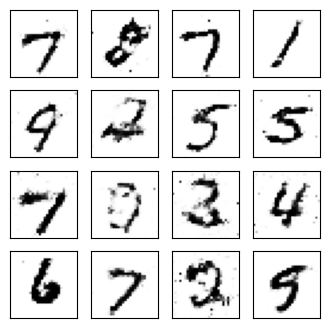

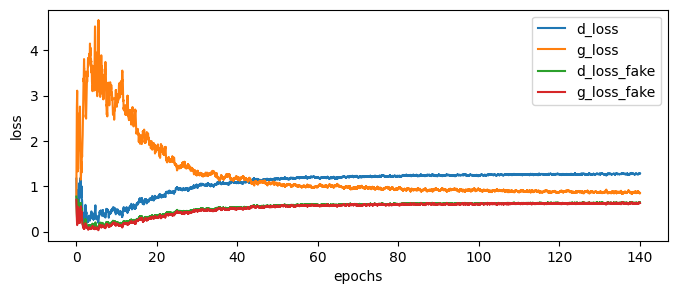

Epoch [141/200], Step[100/469], d_loss: 1.3014, d_loss_fake: 0.5549, g_loss: 0.9921, g_loss_fake: 0.5615, D(x): 0.51, D(G(z)): 0.39
Epoch [141/200], Step[200/469], d_loss: 1.2356, d_loss_fake: 0.6021, g_loss: 0.8971, g_loss_fake: 0.6098, D(x): 0.56, D(G(z)): 0.43
Epoch [141/200], Step[300/469], d_loss: 1.2688, d_loss_fake: 0.6514, g_loss: 0.8786, g_loss_fake: 0.5995, D(x): 0.56, D(G(z)): 0.46
Epoch [141/200], Step[400/469], d_loss: 1.2438, d_loss_fake: 0.5891, g_loss: 0.9083, g_loss_fake: 0.5841, D(x): 0.55, D(G(z)): 0.43
Epoch [142/200], Step[100/469], d_loss: 1.2562, d_loss_fake: 0.6105, g_loss: 0.9357, g_loss_fake: 0.6109, D(x): 0.56, D(G(z)): 0.42
Epoch [142/200], Step[200/469], d_loss: 1.2484, d_loss_fake: 0.5861, g_loss: 0.9744, g_loss_fake: 0.5426, D(x): 0.54, D(G(z)): 0.42
Epoch [142/200], Step[300/469], d_loss: 1.2577, d_loss_fake: 0.5969, g_loss: 0.8687, g_loss_fake: 0.6365, D(x): 0.54, D(G(z)): 0.43
Epoch [142/200], Step[400/469], d_loss: 1.3284, d_loss_fake: 0.7502, g_loss:

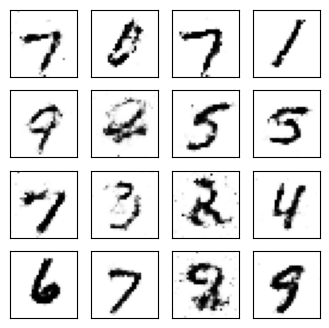

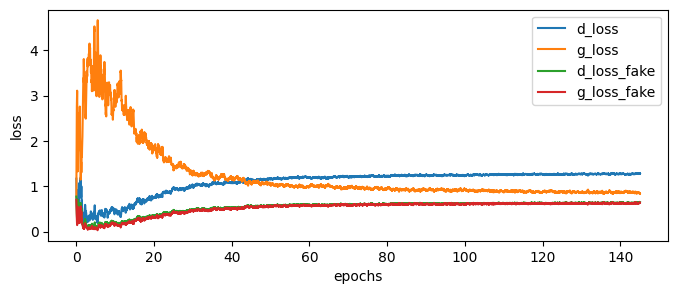

Epoch [146/200], Step[100/469], d_loss: 1.2248, d_loss_fake: 0.6422, g_loss: 0.8088, g_loss_fake: 0.6717, D(x): 0.59, D(G(z)): 0.46
Epoch [146/200], Step[200/469], d_loss: 1.2469, d_loss_fake: 0.5743, g_loss: 1.1329, g_loss_fake: 0.4921, D(x): 0.54, D(G(z)): 0.41
Epoch [146/200], Step[300/469], d_loss: 1.3137, d_loss_fake: 0.6405, g_loss: 0.8505, g_loss_fake: 0.6218, D(x): 0.54, D(G(z)): 0.45
Epoch [146/200], Step[400/469], d_loss: 1.3006, d_loss_fake: 0.6295, g_loss: 0.8846, g_loss_fake: 0.5955, D(x): 0.54, D(G(z)): 0.45
Epoch [147/200], Step[100/469], d_loss: 1.2349, d_loss_fake: 0.5805, g_loss: 0.8795, g_loss_fake: 0.6057, D(x): 0.54, D(G(z)): 0.43
Epoch [147/200], Step[200/469], d_loss: 1.2403, d_loss_fake: 0.6072, g_loss: 0.8490, g_loss_fake: 0.6311, D(x): 0.55, D(G(z)): 0.43
Epoch [147/200], Step[300/469], d_loss: 1.2840, d_loss_fake: 0.6877, g_loss: 0.8572, g_loss_fake: 0.6492, D(x): 0.58, D(G(z)): 0.47
Epoch [147/200], Step[400/469], d_loss: 1.2378, d_loss_fake: 0.5896, g_loss:

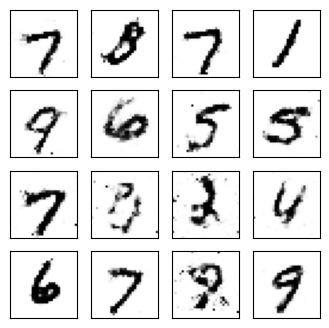

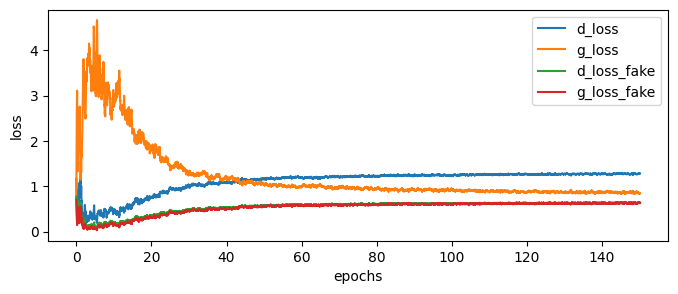

Epoch [151/200], Step[100/469], d_loss: 1.2616, d_loss_fake: 0.6656, g_loss: 0.8634, g_loss_fake: 0.6264, D(x): 0.58, D(G(z)): 0.47
Epoch [151/200], Step[200/469], d_loss: 1.2822, d_loss_fake: 0.5950, g_loss: 0.8641, g_loss_fake: 0.5984, D(x): 0.53, D(G(z)): 0.43
Epoch [151/200], Step[300/469], d_loss: 1.2647, d_loss_fake: 0.6450, g_loss: 0.8624, g_loss_fake: 0.6022, D(x): 0.56, D(G(z)): 0.45
Epoch [151/200], Step[400/469], d_loss: 1.2752, d_loss_fake: 0.6170, g_loss: 0.9219, g_loss_fake: 0.5695, D(x): 0.54, D(G(z)): 0.44
Epoch [152/200], Step[100/469], d_loss: 1.2959, d_loss_fake: 0.6783, g_loss: 0.8429, g_loss_fake: 0.6335, D(x): 0.56, D(G(z)): 0.47
Epoch [152/200], Step[200/469], d_loss: 1.2981, d_loss_fake: 0.7007, g_loss: 0.8829, g_loss_fake: 0.6399, D(x): 0.58, D(G(z)): 0.47
Epoch [152/200], Step[300/469], d_loss: 1.1964, d_loss_fake: 0.6096, g_loss: 0.8690, g_loss_fake: 0.6308, D(x): 0.59, D(G(z)): 0.44
Epoch [152/200], Step[400/469], d_loss: 1.4115, d_loss_fake: 0.7934, g_loss:

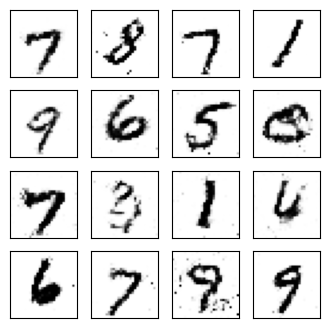

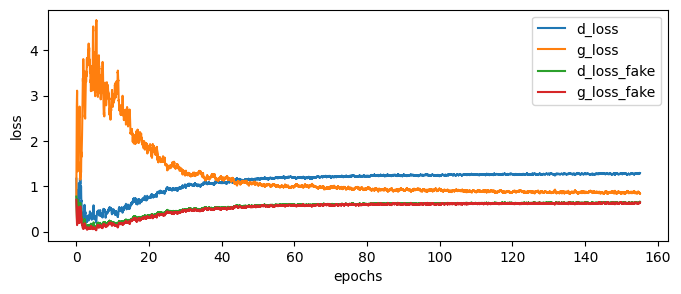

Epoch [156/200], Step[100/469], d_loss: 1.3116, d_loss_fake: 0.6359, g_loss: 0.8220, g_loss_fake: 0.6429, D(x): 0.53, D(G(z)): 0.46
Epoch [156/200], Step[200/469], d_loss: 1.2227, d_loss_fake: 0.6042, g_loss: 0.7897, g_loss_fake: 0.6794, D(x): 0.57, D(G(z)): 0.44
Epoch [156/200], Step[300/469], d_loss: 1.2960, d_loss_fake: 0.5945, g_loss: 0.8840, g_loss_fake: 0.6287, D(x): 0.51, D(G(z)): 0.43
Epoch [156/200], Step[400/469], d_loss: 1.2780, d_loss_fake: 0.6667, g_loss: 0.8318, g_loss_fake: 0.6598, D(x): 0.57, D(G(z)): 0.46
Epoch [157/200], Step[100/469], d_loss: 1.3030, d_loss_fake: 0.6860, g_loss: 0.8285, g_loss_fake: 0.6443, D(x): 0.57, D(G(z)): 0.48
Epoch [157/200], Step[200/469], d_loss: 1.3526, d_loss_fake: 0.7159, g_loss: 0.8728, g_loss_fake: 0.6061, D(x): 0.55, D(G(z)): 0.48
Epoch [157/200], Step[300/469], d_loss: 1.2822, d_loss_fake: 0.6061, g_loss: 0.8988, g_loss_fake: 0.6044, D(x): 0.53, D(G(z)): 0.44
Epoch [157/200], Step[400/469], d_loss: 1.2693, d_loss_fake: 0.6286, g_loss:

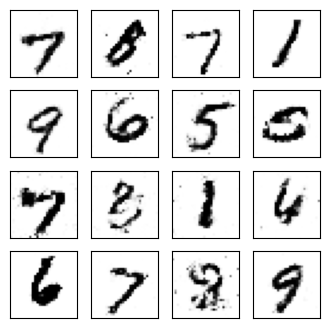

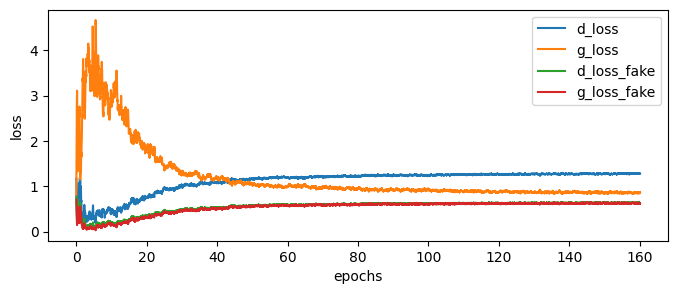

Epoch [161/200], Step[100/469], d_loss: 1.2589, d_loss_fake: 0.6627, g_loss: 0.7580, g_loss_fake: 0.6927, D(x): 0.57, D(G(z)): 0.47
Epoch [161/200], Step[200/469], d_loss: 1.3418, d_loss_fake: 0.6789, g_loss: 0.8199, g_loss_fake: 0.6493, D(x): 0.54, D(G(z)): 0.47
Epoch [161/200], Step[300/469], d_loss: 1.3119, d_loss_fake: 0.6799, g_loss: 0.8225, g_loss_fake: 0.6479, D(x): 0.55, D(G(z)): 0.48
Epoch [161/200], Step[400/469], d_loss: 1.2853, d_loss_fake: 0.6131, g_loss: 0.9654, g_loss_fake: 0.5350, D(x): 0.54, D(G(z)): 0.44
Epoch [162/200], Step[100/469], d_loss: 1.2494, d_loss_fake: 0.6983, g_loss: 0.8560, g_loss_fake: 0.6451, D(x): 0.60, D(G(z)): 0.48
Epoch [162/200], Step[200/469], d_loss: 1.3653, d_loss_fake: 0.7347, g_loss: 0.7489, g_loss_fake: 0.7056, D(x): 0.56, D(G(z)): 0.49
Epoch [162/200], Step[300/469], d_loss: 1.2915, d_loss_fake: 0.7014, g_loss: 0.8062, g_loss_fake: 0.6761, D(x): 0.57, D(G(z)): 0.48
Epoch [162/200], Step[400/469], d_loss: 1.3598, d_loss_fake: 0.6875, g_loss:

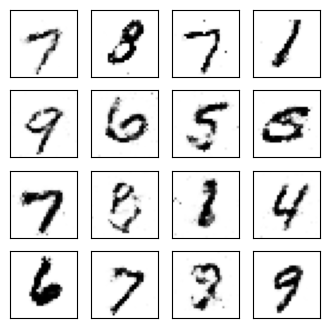

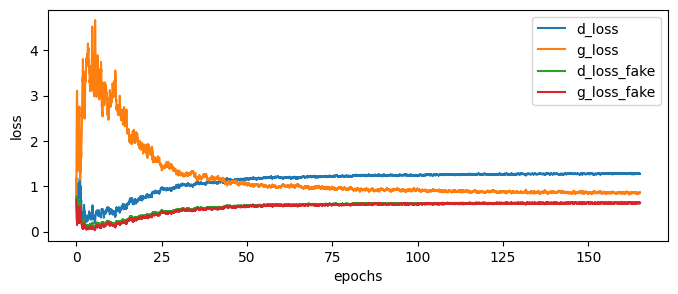

Epoch [166/200], Step[100/469], d_loss: 1.1983, d_loss_fake: 0.6056, g_loss: 0.8741, g_loss_fake: 0.6326, D(x): 0.58, D(G(z)): 0.43
Epoch [166/200], Step[200/469], d_loss: 1.2544, d_loss_fake: 0.6281, g_loss: 0.8536, g_loss_fake: 0.6178, D(x): 0.55, D(G(z)): 0.45
Epoch [166/200], Step[300/469], d_loss: 1.1938, d_loss_fake: 0.5604, g_loss: 0.8903, g_loss_fake: 0.5960, D(x): 0.56, D(G(z)): 0.41
Epoch [166/200], Step[400/469], d_loss: 1.2220, d_loss_fake: 0.5997, g_loss: 0.8074, g_loss_fake: 0.6533, D(x): 0.56, D(G(z)): 0.44
Epoch [167/200], Step[100/469], d_loss: 1.3135, d_loss_fake: 0.6506, g_loss: 0.8662, g_loss_fake: 0.6239, D(x): 0.53, D(G(z)): 0.46
Epoch [167/200], Step[200/469], d_loss: 1.3297, d_loss_fake: 0.6410, g_loss: 0.8515, g_loss_fake: 0.6177, D(x): 0.53, D(G(z)): 0.45
Epoch [167/200], Step[300/469], d_loss: 1.3014, d_loss_fake: 0.6279, g_loss: 0.8875, g_loss_fake: 0.5962, D(x): 0.54, D(G(z)): 0.45
Epoch [167/200], Step[400/469], d_loss: 1.2924, d_loss_fake: 0.6757, g_loss:

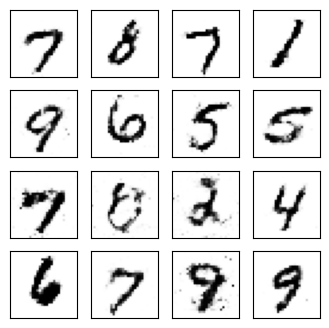

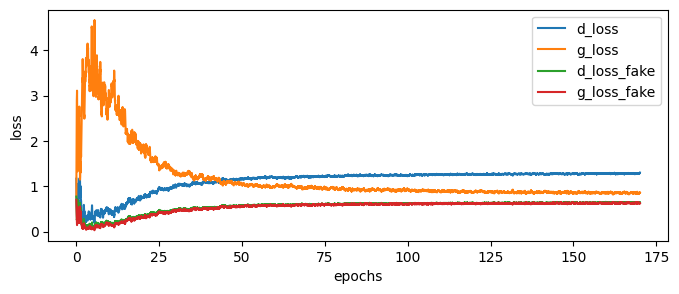

Epoch [171/200], Step[100/469], d_loss: 1.3062, d_loss_fake: 0.7051, g_loss: 0.8589, g_loss_fake: 0.6113, D(x): 0.57, D(G(z)): 0.48
Epoch [171/200], Step[200/469], d_loss: 1.2811, d_loss_fake: 0.7001, g_loss: 0.7475, g_loss_fake: 0.7267, D(x): 0.58, D(G(z)): 0.48
Epoch [171/200], Step[300/469], d_loss: 1.3112, d_loss_fake: 0.6230, g_loss: 0.8376, g_loss_fake: 0.6548, D(x): 0.52, D(G(z)): 0.45
Epoch [171/200], Step[400/469], d_loss: 1.2682, d_loss_fake: 0.6295, g_loss: 0.8775, g_loss_fake: 0.6349, D(x): 0.56, D(G(z)): 0.44
Epoch [172/200], Step[100/469], d_loss: 1.3023, d_loss_fake: 0.7480, g_loss: 0.7151, g_loss_fake: 0.7591, D(x): 0.60, D(G(z)): 0.51
Epoch [172/200], Step[200/469], d_loss: 1.2795, d_loss_fake: 0.6779, g_loss: 0.8451, g_loss_fake: 0.6293, D(x): 0.57, D(G(z)): 0.47
Epoch [172/200], Step[300/469], d_loss: 1.2924, d_loss_fake: 0.5844, g_loss: 0.9173, g_loss_fake: 0.6154, D(x): 0.52, D(G(z)): 0.43
Epoch [172/200], Step[400/469], d_loss: 1.3158, d_loss_fake: 0.6651, g_loss:

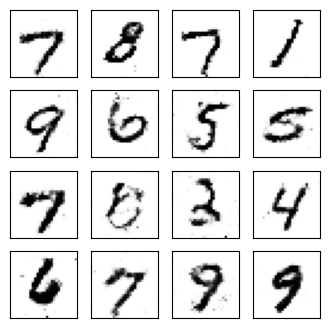

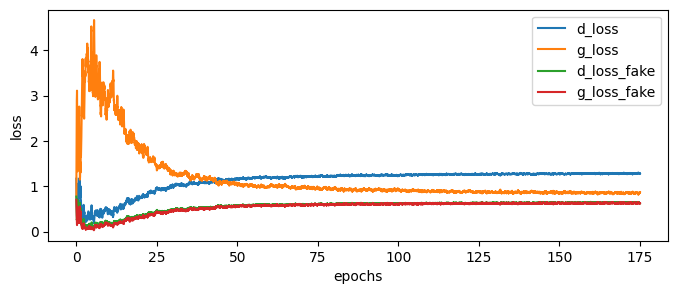

Epoch [176/200], Step[100/469], d_loss: 1.2987, d_loss_fake: 0.6657, g_loss: 0.8947, g_loss_fake: 0.5692, D(x): 0.55, D(G(z)): 0.47
Epoch [176/200], Step[200/469], d_loss: 1.2934, d_loss_fake: 0.6658, g_loss: 0.8275, g_loss_fake: 0.6587, D(x): 0.56, D(G(z)): 0.47
Epoch [176/200], Step[300/469], d_loss: 1.3361, d_loss_fake: 0.6149, g_loss: 0.9179, g_loss_fake: 0.6007, D(x): 0.51, D(G(z)): 0.44
Epoch [176/200], Step[400/469], d_loss: 1.3552, d_loss_fake: 0.7195, g_loss: 0.8240, g_loss_fake: 0.6502, D(x): 0.56, D(G(z)): 0.49
Epoch [177/200], Step[100/469], d_loss: 1.2795, d_loss_fake: 0.6611, g_loss: 0.8428, g_loss_fake: 0.6513, D(x): 0.56, D(G(z)): 0.46
Epoch [177/200], Step[200/469], d_loss: 1.2684, d_loss_fake: 0.6015, g_loss: 0.8853, g_loss_fake: 0.6033, D(x): 0.54, D(G(z)): 0.44
Epoch [177/200], Step[300/469], d_loss: 1.3061, d_loss_fake: 0.6023, g_loss: 0.9158, g_loss_fake: 0.5855, D(x): 0.52, D(G(z)): 0.43
Epoch [177/200], Step[400/469], d_loss: 1.2707, d_loss_fake: 0.6240, g_loss:

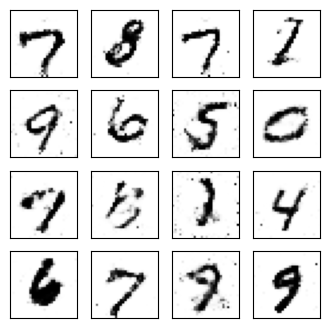

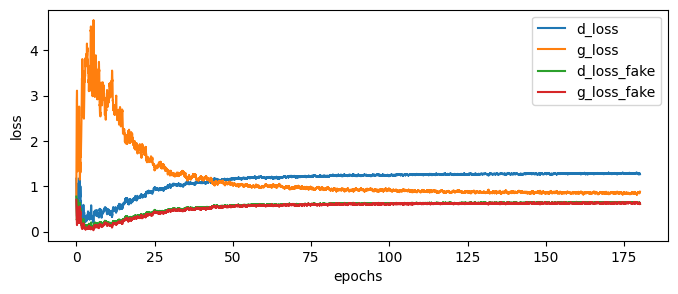

Epoch [181/200], Step[100/469], d_loss: 1.2726, d_loss_fake: 0.6502, g_loss: 0.8187, g_loss_fake: 0.6273, D(x): 0.56, D(G(z)): 0.46
Epoch [181/200], Step[200/469], d_loss: 1.2323, d_loss_fake: 0.6420, g_loss: 0.7650, g_loss_fake: 0.7171, D(x): 0.58, D(G(z)): 0.45
Epoch [181/200], Step[300/469], d_loss: 1.2663, d_loss_fake: 0.6736, g_loss: 0.7682, g_loss_fake: 0.7059, D(x): 0.57, D(G(z)): 0.47
Epoch [181/200], Step[400/469], d_loss: 1.3357, d_loss_fake: 0.7144, g_loss: 0.7326, g_loss_fake: 0.7229, D(x): 0.55, D(G(z)): 0.49
Epoch [182/200], Step[100/469], d_loss: 1.2015, d_loss_fake: 0.5960, g_loss: 0.8589, g_loss_fake: 0.6339, D(x): 0.57, D(G(z)): 0.43
Epoch [182/200], Step[200/469], d_loss: 1.2887, d_loss_fake: 0.5969, g_loss: 0.8964, g_loss_fake: 0.6147, D(x): 0.53, D(G(z)): 0.43
Epoch [182/200], Step[300/469], d_loss: 1.2431, d_loss_fake: 0.6848, g_loss: 0.8179, g_loss_fake: 0.6607, D(x): 0.60, D(G(z)): 0.47
Epoch [182/200], Step[400/469], d_loss: 1.1961, d_loss_fake: 0.5579, g_loss:

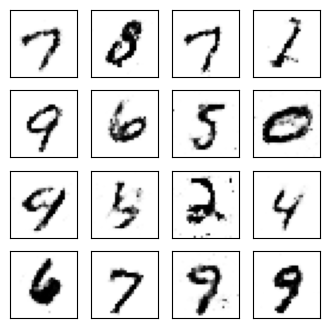

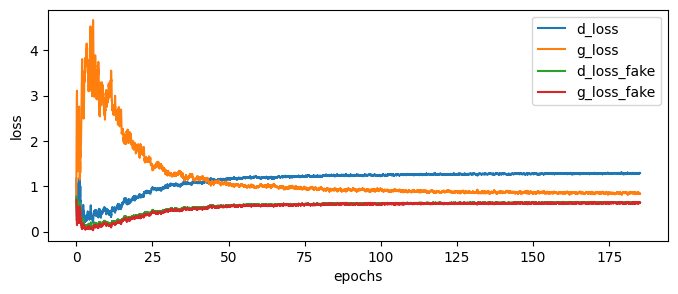

Epoch [186/200], Step[100/469], d_loss: 1.2748, d_loss_fake: 0.6544, g_loss: 0.8292, g_loss_fake: 0.6821, D(x): 0.57, D(G(z)): 0.46
Epoch [186/200], Step[200/469], d_loss: 1.3215, d_loss_fake: 0.6315, g_loss: 0.8468, g_loss_fake: 0.6300, D(x): 0.52, D(G(z)): 0.45
Epoch [186/200], Step[300/469], d_loss: 1.2991, d_loss_fake: 0.7000, g_loss: 0.8491, g_loss_fake: 0.6256, D(x): 0.57, D(G(z)): 0.48
Epoch [186/200], Step[400/469], d_loss: 1.2675, d_loss_fake: 0.6278, g_loss: 0.7779, g_loss_fake: 0.6902, D(x): 0.55, D(G(z)): 0.45
Epoch [187/200], Step[100/469], d_loss: 1.2463, d_loss_fake: 0.6525, g_loss: 0.8198, g_loss_fake: 0.6507, D(x): 0.58, D(G(z)): 0.46
Epoch [187/200], Step[200/469], d_loss: 1.3220, d_loss_fake: 0.7037, g_loss: 0.7633, g_loss_fake: 0.7107, D(x): 0.56, D(G(z)): 0.48
Epoch [187/200], Step[300/469], d_loss: 1.3038, d_loss_fake: 0.6128, g_loss: 0.8892, g_loss_fake: 0.5880, D(x): 0.52, D(G(z)): 0.44
Epoch [187/200], Step[400/469], d_loss: 1.3282, d_loss_fake: 0.6792, g_loss:

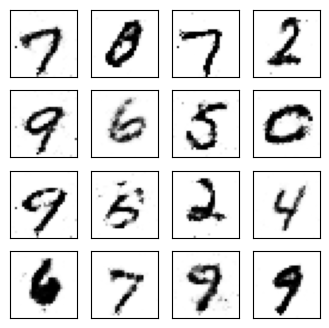

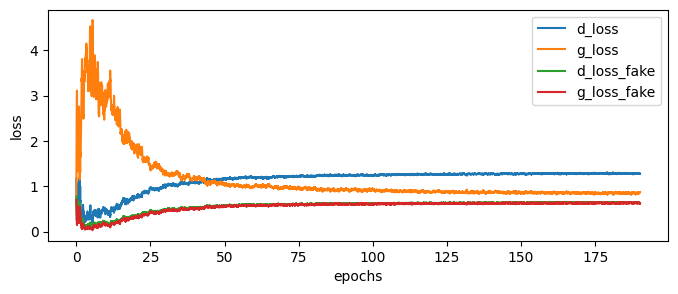

Epoch [191/200], Step[100/469], d_loss: 1.2658, d_loss_fake: 0.6122, g_loss: 0.8889, g_loss_fake: 0.5911, D(x): 0.54, D(G(z)): 0.44
Epoch [191/200], Step[200/469], d_loss: 1.2616, d_loss_fake: 0.6030, g_loss: 0.8949, g_loss_fake: 0.6034, D(x): 0.54, D(G(z)): 0.43
Epoch [191/200], Step[300/469], d_loss: 1.3327, d_loss_fake: 0.7091, g_loss: 0.7931, g_loss_fake: 0.6570, D(x): 0.55, D(G(z)): 0.49
Epoch [191/200], Step[400/469], d_loss: 1.2079, d_loss_fake: 0.5533, g_loss: 0.9032, g_loss_fake: 0.5982, D(x): 0.54, D(G(z)): 0.41
Epoch [192/200], Step[100/469], d_loss: 1.3086, d_loss_fake: 0.7123, g_loss: 0.8051, g_loss_fake: 0.6773, D(x): 0.57, D(G(z)): 0.49
Epoch [192/200], Step[200/469], d_loss: 1.3163, d_loss_fake: 0.7467, g_loss: 0.8221, g_loss_fake: 0.6437, D(x): 0.58, D(G(z)): 0.50
Epoch [192/200], Step[300/469], d_loss: 1.2704, d_loss_fake: 0.6785, g_loss: 0.8427, g_loss_fake: 0.6210, D(x): 0.57, D(G(z)): 0.47
Epoch [192/200], Step[400/469], d_loss: 1.2957, d_loss_fake: 0.6786, g_loss:

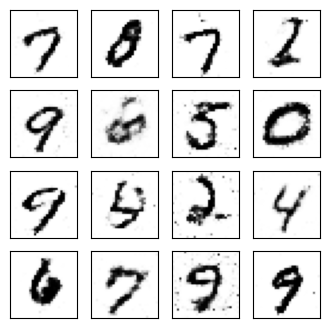

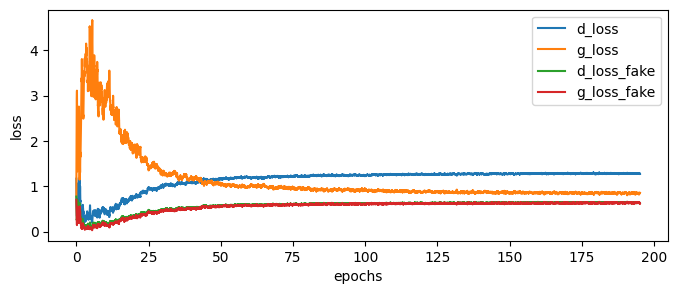

Epoch [196/200], Step[100/469], d_loss: 1.2856, d_loss_fake: 0.6388, g_loss: 0.8773, g_loss_fake: 0.5894, D(x): 0.54, D(G(z)): 0.46
Epoch [196/200], Step[200/469], d_loss: 1.2026, d_loss_fake: 0.5797, g_loss: 0.9118, g_loss_fake: 0.5589, D(x): 0.56, D(G(z)): 0.43
Epoch [196/200], Step[300/469], d_loss: 1.2900, d_loss_fake: 0.6091, g_loss: 0.8545, g_loss_fake: 0.6270, D(x): 0.53, D(G(z)): 0.44
Epoch [196/200], Step[400/469], d_loss: 1.3424, d_loss_fake: 0.6198, g_loss: 0.8789, g_loss_fake: 0.5894, D(x): 0.51, D(G(z)): 0.44
Epoch [197/200], Step[100/469], d_loss: 1.2951, d_loss_fake: 0.6407, g_loss: 0.8826, g_loss_fake: 0.5994, D(x): 0.54, D(G(z)): 0.46
Epoch [197/200], Step[200/469], d_loss: 1.2386, d_loss_fake: 0.6301, g_loss: 0.8071, g_loss_fake: 0.6378, D(x): 0.56, D(G(z)): 0.46
Epoch [197/200], Step[300/469], d_loss: 1.2799, d_loss_fake: 0.6348, g_loss: 0.9076, g_loss_fake: 0.5984, D(x): 0.55, D(G(z)): 0.45
Epoch [197/200], Step[400/469], d_loss: 1.3133, d_loss_fake: 0.6551, g_loss:

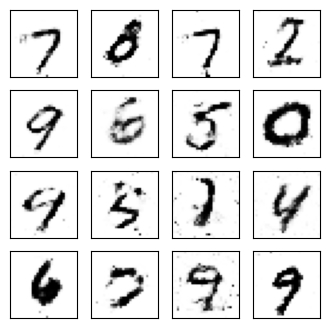

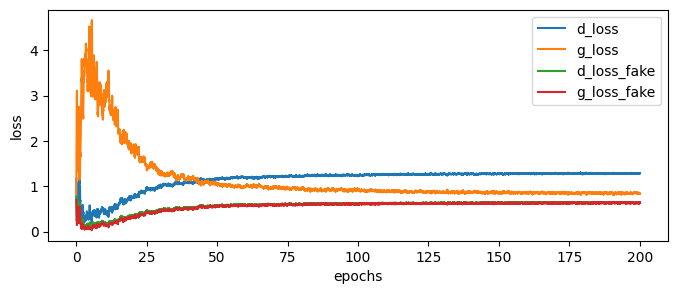

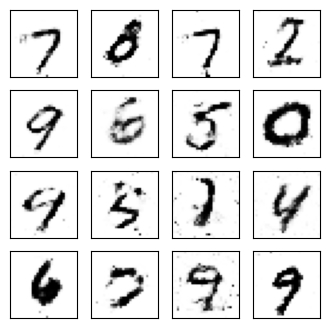

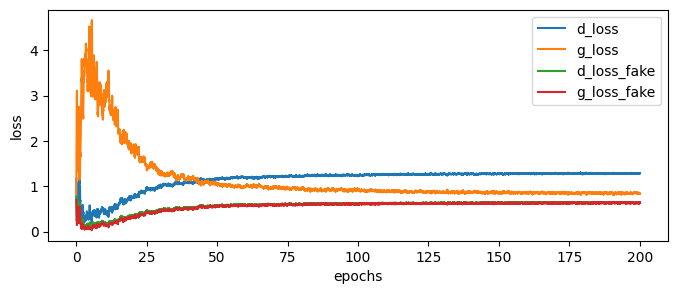

In [10]:
##################
### Problem 2: Ablation study 1, 2, and 3
##################
# set number of epochs and initialize figure counter

# Ablation 1: Double the size of the channels in generator

dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = False

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(channels=np.array([128, 256, 512])*2, with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

num_epochs = 200
d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)

# **2. Conditional GAN**

In [ ]:
num_epochs = 500
dim_z = 100

num_test_samples = 16
test_noise = Variable(torch.randn(num_test_samples, dim_z).to(device))
d_freq = 1

with_condition = True

discriminator = Discriminator(with_condition=with_condition).to(device)
generator = Generator(with_condition=with_condition).to(device)

lr = 0.0002
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)

d_losses, d_losses_fake, g_losses, g_losses_fake = train_main_loop(generator, discriminator, d_optimizer, g_optimizer, test_noise, num_epochs, d_freq, with_condition)
monitor_images(generator, test_noise, with_condition=with_condition)
monitor_losses(d_losses, d_losses_fake, g_losses, g_losses_fake)